# Physics Informed Neural Networks for 2nd Order Harmonic Oscillators

Importing dependencies and setting seed

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import functools
from math import sqrt
import seaborn as sns
from tqdm import tqdm

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(10)
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sns.set_theme()

## Harmonic Oscillator

##### Ordinary Differential Equation
$$ \frac{d^2x}{dz^2} + 2 \cdot \zeta \cdot \frac{dx}{dz} + x(z) = 0 $$
The given $II^{nd}$ Order Harmonic Oscillator for $ z \in [0,20] $ has the following conditions,


1. &nbsp; $ \zeta \in [0.1, 0.4] $
2. &nbsp; $ x(0) = x_0 = 0.7$
3. &nbsp; $\frac{dx}{dz}(0) = v_0 = 1.2$

\
$\zeta < 1$ is a case of underdamped harmonics, the solution for which is given as,
$$x(z) = e^{-\zeta z }[ C_1 cos(\sqrt{1-\zeta^2} \cdot z) + C_2 sin(\sqrt{1-\zeta^2} \cdot z) ]$$

\
we start by determining the values for the arbitrary constants $C_1$ and $C_2$ using the given inital conditions,
$$
\begin{aligned}
    c_1 &= x_0 \quad & C_2 &= \frac{v_0 + \zeta C_1} {\sqrt{1-\zeta^2}}
\end{aligned}
$$

\
And now we do the following 
1. define an analytical function `harmonic_oscillator(z, zeta, C1, C2)` based on the above determined solution
2. define a domain $z \in [0,40]$ for analytical values of $x(z)$ &nbsp; (Note: values [0,20] will serve as domain for datapoints and values [20,40] will serve as domain for collocations points which we'll use in future for calculating physics based loss)
3. Generate datapoints with some noise using `harmonic_oscillator`
4. Plot the following:
    (i) Analytical solution
    (ii) Datapoints

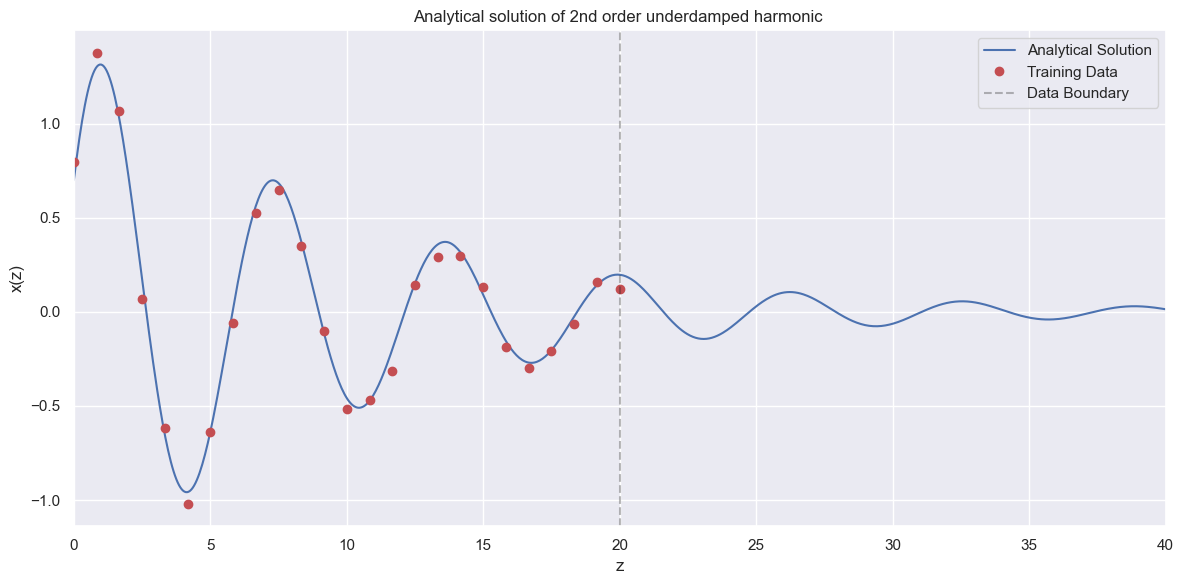

In [2]:
# CONSTANTS
X_0 = 0.7  # Initial position
V_0 = 1.2  # Initial velocity
zeta = 0.1   # Damping ratio

# Analytical solution parameters
C1 = X_0
C2 = (V_0 + zeta*C1) / sqrt(1-zeta**2)

def harmonic_oscillator(z, zeta, C1, C2):
    """Analytical solution for the damped harmonic oscillator"""
    if not isinstance(z, torch.Tensor):
        torch.Tensor(z, dtype=torch.float32, requires_grad=True)
    x = torch.exp(-zeta*z) * (C1*torch.cos(sqrt(1-zeta**2)*z) + C2*torch.sin(sqrt(1-zeta**2)*z))
    return x

# Generating analytical eqn data
z = torch.linspace(0, 40, 800)
eqn = functools.partial(harmonic_oscillator, zeta=zeta, C1=C1, C2=C2)
x_analytical = eqn(z)

# Generating training data with noise
NUM_OF_TRAINING_POINTS = 25
datapoints_z = torch.linspace(0, 20, NUM_OF_TRAINING_POINTS)
datapoints_x = eqn(datapoints_z) + 0.05*torch.randn(NUM_OF_TRAINING_POINTS)

plt.figure(figsize=(12, 6))
plt.plot(z.numpy(), x_analytical.numpy(), 'b-', label='Analytical Solution')
plt.plot(datapoints_z.numpy(), datapoints_x.numpy(), 'ro', label='Training Data')
plt.axvline(x=20, color='k', linestyle='--', alpha=0.3, label='Data Boundary')
plt.legend()
plt.title('Analytical solution of 2nd order underdamped harmonic ')
plt.xlabel('z')
plt.ylabel('x(z)')
plt.xlim(0, 40)
plt.tight_layout()

## (1) Defining a Neural Network Model

We first define the architecture of the model which we will later train for modeling the given ODE. This model will be a **feed-forward fully-connected neural network** with the following hyperparameters, \
i. **Input dimensions**: dimension of a datapoint in the input tensor \
ii. **Output dimensions**: dimension of a datapoint in the output tensor \
iii. **Hidden units**: Number of neurons in the hidden layer of the model

In [3]:
class PINN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_units, num_layers=4):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_units = hidden_units
        self.num_layers = num_layers

        # Create layers with consistent activation
        layers = []
        layers.append(nn.Linear(input_dim, hidden_units))
        layers.append(nn.Tanh())  # Consistent Tanh activation
        
        for _ in range(num_layers):
            layers.append(nn.Linear(hidden_units, hidden_units))
            layers.append(nn.Tanh())
        
        layers.append(nn.Linear(hidden_units, output_dim))
        
        self.layers = nn.Sequential(*layers)
        
        # Improved weight initialization
        self._initialize_weights()

    def _initialize_weights(self):
        """Improved weight initialization"""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                # Kaiming initialization for Tanh activations
                nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='tanh')
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
        x = x.reshape(-1, self.input_dim).to(device)
        return self.layers(x)
    
    def get_derivatives(self, x):
        """Optimized derivative computation"""
        x_tensor = x.clone().detach().requires_grad_(True).to(device)
        
        # Enable gradient tracking
        with torch.enable_grad():
            y = self.forward(x_tensor)
            
            # First derivative
            dy_dx = torch.autograd.grad(
                y, x_tensor, 
                grad_outputs=torch.ones_like(y),
                create_graph=True,
                retain_graph=True
            )[0]
            
            # Second derivative
            dy2_dx2 = torch.autograd.grad(
                dy_dx, x_tensor, 
                grad_outputs=torch.ones_like(dy_dx),
                create_graph=True,
                retain_graph=True
            )[0]
        
        return y, dy_dx, dy2_dx2

## (2) Defining Training Function

We define a training utility function `train_model` which has following \
**Inputs:**
  - **model**: *torch.nn.Module*\
    model object
  - **z_data**: *torch.Tensor*\
    datapoints for $z$
  - **zeta**: *float*\
    value of zeta for physics-loss
  - **x_0**: *float*\
    value of $x(0)$ for initial condition loss
  - **v_0**: *float*\
    value of $ dx/dz(0)$ for initial condition loss
  - **num_epochs**: *int*\
    number of training epochs. default set to *10000*
  - **data_weight**: *float*\
    weight for data-loss term. default set to *1.0*
  - **ic_weight**: *float*\
    weight for ic-loss term. default set to *10.0*
  - **physics_weight**: *float*\
    weight for physics-loss term. default set to *10.0*
  - **num_collocation**: *int*\
    number of collocation points to be used in calculating physics loss. default set to *400*
  - **domain**: *Tuple*, *List*\
    domain for collocation points. default set to *(0,40)*
  - **lr**: *float*\
    learning rate. default set to *1e-3*
  - **plot_training**: *bool*\
    plot curves for the model predictions at *25%, 50%, 75% and 100%* of epochs during training

**Outputs:**
  - *Dict* \
    a dict containing total_loss, data_loss, physics_loss, ic_loss during the training

In [4]:
def train_model(
    model, 
    z_data, 
    x_data, 
    zeta, 
    X_0, 
    V_0, 
    num_epochs=10000,
    data_weight=1.0, 
    ic_weight=10.0, 
    physics_weight=10.0,
    num_collocation_points=400, 
    domain=(0, 40), 
    lr=1e-3,
    plot_training=True
):
    
    z_data = z_data.reshape(-1, 1).to(device)
    x_data = x_data.reshape(-1, 1).to(device)

    # Collocation points with non-uniform distribution
    z_collocation = torch.linspace(domain[0], domain[1], num_collocation_points) \
        .reshape(-1, 1).requires_grad_(True).to(device)
    
    # Initial condition point
    z_ic = torch.tensor([[0.0]], dtype=torch.float32, requires_grad=True).to(device)
    
    # Create evaluation points for plotting
    z_eval = torch.linspace(domain[0], domain[1], 800).reshape(-1, 1).to(device)
    
    # Adaptive optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.5, 
        patience=200, 
        min_lr=1e-5, 
        verbose=True
    )

    mse_loss = nn.MSELoss()
    history = {
        'total_loss': [],
        'data_loss': [],
        'physics_loss': [],
        'ic_loss': []
    }
    
    # Store solutions at different training stages
    progress_solutions = {}
    
    # Calculate checkpoint epochs for visualization
    checkpoints = [int(num_epochs * p) for p in [0.25, 0.5, 0.75, 1.0]]

    with tqdm(range(num_epochs), desc="Training", unit="epoch") as pbar:
        for epoch in pbar:
            optimizer.zero_grad()

            # Data loss
            x_pred = model(z_data)
            data_loss = mse_loss(x_data, x_pred)

            # Physics loss with residual computation
            x_collocation, dx_dz, dx2_dz2 = model.get_derivatives(z_collocation)
            ode_residual = dx2_dz2 + 2 * zeta * dx_dz + x_collocation
            physics_loss = torch.mean(ode_residual ** 2)

            # Initial condition losses
            x_ic, dx_dz_ic, _ = model.get_derivatives(z_ic)
            ic_position_loss = torch.mean((x_ic - X_0) ** 2)
            ic_velocity_loss = torch.mean((dx_dz_ic - V_0) ** 2)
            ic_loss = ic_position_loss + ic_velocity_loss

            # Weighted total loss
            total_loss = (
                data_weight * data_loss + 
                physics_weight * physics_loss + 
                ic_weight * ic_loss
            )
            
            total_loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            scheduler.step(total_loss)

            # Record loss history
            history['total_loss'].append(total_loss.item())
            history['data_loss'].append(data_loss.item())
            history['physics_loss'].append(physics_loss.item())
            history['ic_loss'].append(ic_loss.item())

            # Update progress bar
            pbar.set_postfix({
                'total': f'{total_loss.item():.5f}',
                'data': f'{data_loss.item():.5f}',
                'phys': f'{physics_loss.item():.5f}',
                'ic': f'{ic_loss.item():.5f}'
            })
            
            # Capture solutions at checkpoint epochs (25%, 50%, 75%, 100%)
            if epoch + 1 in checkpoints:
                progress_percentage = int(((epoch + 1) / num_epochs) * 100)
                
                # Get current model predictions
                model.eval()  # Set to evaluation mode
                with torch.no_grad():
                    predictions = model(z_eval).detach().cpu().numpy()
                model.train()  # Set back to training mode
                
                # Store the current solution
                progress_solutions[progress_percentage] = predictions.copy()
    
    if plot_training:
    # After training is complete, plot the solutions at different stages in subplots
        plt.figure(figsize=(12, 10))
        for i, percentage in enumerate([25, 50, 75, 100]):
            plt.subplot(2, 2, i+1)
            
            # Plot analytical solution if available
            try:
                plt.plot(z.numpy(), x_analytical.numpy(), 'b-', label='Analytical Solution')
            except NameError:
                pass  # Analytical solution not available
            
            # Plot training data points
            plt.scatter(z_data.cpu().detach().numpy(), x_data.cpu().detach().numpy(), 
                        color="tab:red", s=20, alpha=0.6, label='Training Data')
            
            # Plot PINN prediction at this stage
            plt.plot(z_eval.cpu().numpy(), progress_solutions[percentage], 'g--', label='PINN Solution')
            
            plt.axvline(x=20, color='k', linestyle='--', alpha=0.3, label='Data Boundary')
            plt.title(f'{percentage}% Training ({int(percentage*num_epochs/100)}/{num_epochs} epochs)')
            plt.xlabel('z')
            plt.ylabel('x(z)')
            plt.legend(loc='upper right', fontsize='small')
        
        plt.tight_layout()
        # plt.savefig("Training_progress_subplots.png", bbox_inches='tight')
        plt.show()

    return history


## (3) Training a Neural Network without Physics Loss

First we train a conventional neural network without using physics-loss. Here are the insights that we can gather,
1. During it's training we plot the model's predictions to observe how the model is learning. we can see that model has learned the pattern based on mere datapoints (for $z \in [0,20]$) within the first 5000 epochs itself however the model is unable to learn the pattern beyond it's training domain ie $z \in [20,40]$.
2. The data-loss curve confirms that the model has almost learned the pattern with almost negligible drop in data-loss beyond the 7500 epoch mark.


/Users/ashishdalal/miniconda3/envs/mldl_env/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Training: 100%|█| 20000/20000 [01:17<00:00, 257.55epoch/s, total=0.00001, data=0


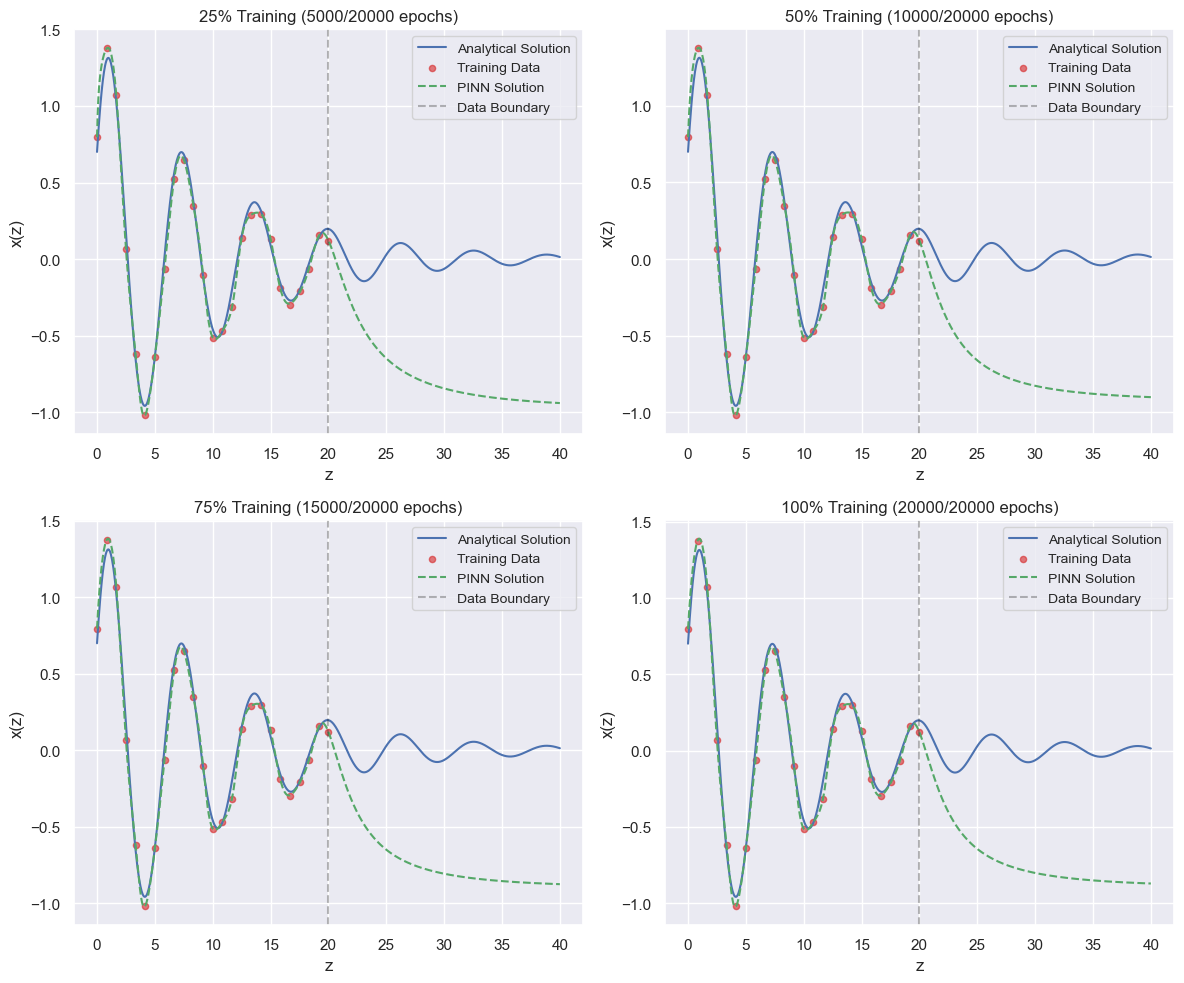

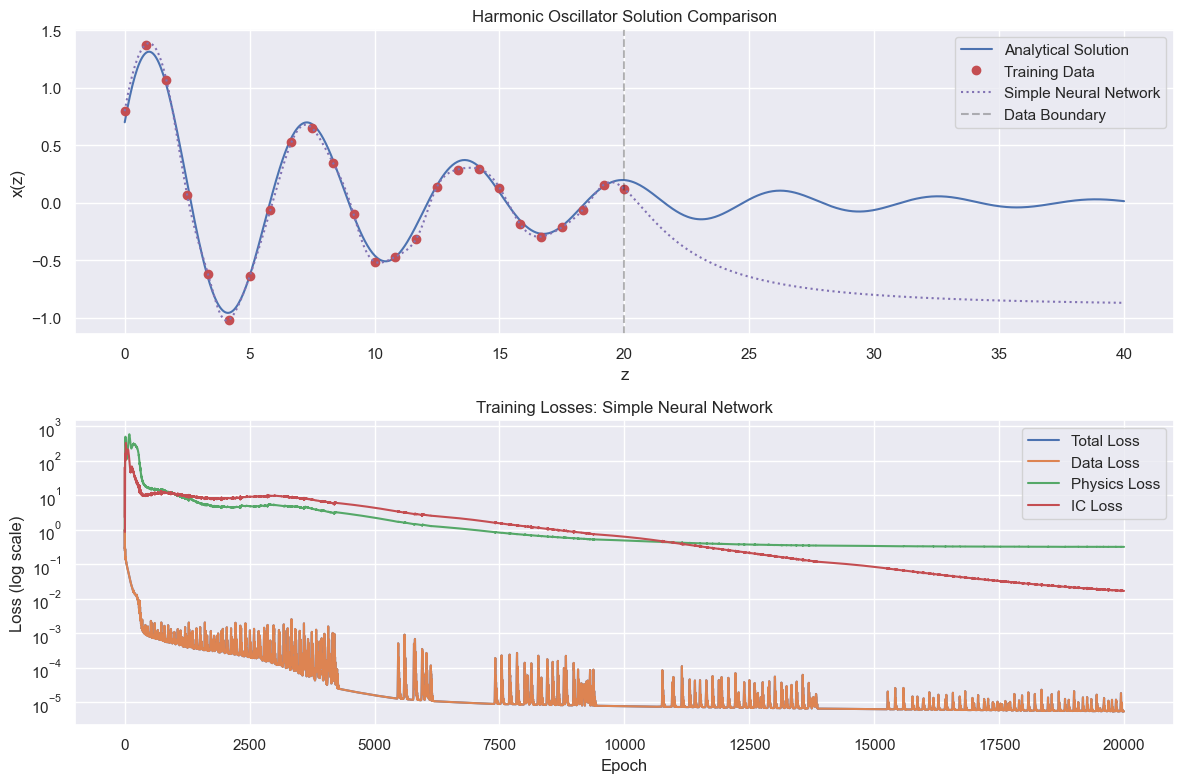

In [6]:
# Training parameters
INPUT_DIM = 1
OUTPUT_DIM = 1
HIDDEN_UNITS = 64
NUM_EPOCHS = 20000
LEARNING_RATE = 1e-3


# Create and train the model
simple_nn = PINN(INPUT_DIM, OUTPUT_DIM, HIDDEN_UNITS).to(device)
history = train_model(
    simple_nn, 
    datapoints_z, 
    datapoints_x, 
    zeta=zeta,  
    X_0=X_0,  # Initial position 
    V_0=V_0,  # Initial velocity
    lr=LEARNING_RATE, 
    num_epochs=NUM_EPOCHS,
    physics_weight=0,
    ic_weight=0
)

# Evaluate and plot results
z_eval = torch.linspace(0, 40, 800).reshape(-1, 1).to(device)
predictions = simple_nn(z_eval).detach().cpu().numpy()

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(z.numpy(), x_analytical.numpy(), 'b-', label='Analytical Solution')
plt.plot(datapoints_z.numpy(), datapoints_x.numpy(), 'ro', label='Training Data')
plt.plot(z_eval.cpu().numpy(), predictions, 'm:', label='Simple Neural Network')
plt.axvline(x=20, color='k', linestyle='--', alpha=0.3, label='Data Boundary')
plt.legend()
plt.title('Harmonic Oscillator Solution Comparison')
plt.xlabel('z')
plt.ylabel('x(z)')

plt.subplot(2, 1, 2)
plt.semilogy(history['total_loss'], label='Total Loss')
plt.semilogy(history['data_loss'], label='Data Loss')
plt.semilogy(history['physics_loss'], label='Physics Loss')
plt.semilogy(history['ic_loss'], label='IC Loss')
plt.legend()
plt.title('Training Losses: Simple Neural Network')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.tight_layout()

## (4) Traning a Physics Informed Neural Network

Now we train the Physics Informed Neural Network by defining a combination of Loss functions. we use two loss functions in addition to the MSE loss function (for data-loss) to help the model learn the information via the underlying physics loss.

1. Physics Loss: \
   let,
   $$g(z,\,x) = \frac{d^2x}{dz^2} \;+\; 2 \cdot \zeta \cdot \frac{dx}{dz} \;+\; x = 0$$
    so,
   $$
   \begin{aligned}
   \mathcal{L}_{physics}(\theta) &= \frac{1}{M}\sum_{j=1}^{M}\; g \, (z_j, \, f(z_j \, | \, \theta)) \\
    &= \sum_{j=1}^{M}\; \frac{d^2}{dz^2}f(z_j\,|\, \theta) \;+\; 2 \cdot \zeta \cdot \frac{d}{dz}f(z_j\,| \,\theta) \;+\; f(z_j\,| \, \theta)
   \end{aligned}
   $$
2. Inital Condition Loss: \
   This loss term is used to help model satisfy intial conditions of the problem by penalizing any deviations in predictions from the given initial loss. It's defined as,
   $$
   \mathcal{L}_{ic}(\theta) = \| f(z=0 \, |\, \theta) - x_0\|^2 \;+\; \| \frac{d}{dz}f(z\, | \, \theta) \; (z=0) - v_0 \|^2
   $$

   the first term represents the deviation in prediction of $x_0$, and the second represents deviation in prediction of first derivative
$v_0$ at $z=0$

\
Together the final loss-function is defined as,
$$
\mathcal{L}(\theta) = \lambda_{data} \cdot \mathcal{L}_{data} \;+\; \lambda_{physics} \cdot \mathcal{L}_{physics} \;+\; \lambda_{ic} \cdot \mathcal{L}_{ic}
$$

The insights that we get from training this PINN are,
1. The model's total-loss almost reached it's minimum value at 7500 epoch mark
2. Even though the model's total-loss has plataeued at $7500^{th}$ epoch that does not mean that the model is done training. In fact as seen from the graphs plotted during training we can see that in the first quarter of training (ie. till epoch 5000) the model has learned the pattern quite well by fitting well to the datapoints given to it, however in the suceeding epochs the model is trying to not deviate from the analytical curve by receeding from the datapoints that seem to carry comparatively higher noise. Finaly, post training we can see how the curves obtained from a conventional neural network differs from the PINNs in that, \
    &nbsp; i. NN has learned to fit the datapoints while PINN tries to find a balance between fitting the curve to the datapoints and the analytical solution \
    &nbsp; ii. Outside of the training domain ie. $z \in [20,40]$ the NN just wanders off the solution curve while the PINN stays close to it and has in fact managed to learn the pattern to some extent outside its training domain
5. This physics based model training, while approximating a better fit curve in comparison, comes at a cost of higher compute than a conventional neural network. Also, involvement of first and second order derivatives in the loss function makes the training process complex and considerably slower.

Training: 100%|█| 20000/20000 [01:12<00:00, 276.97epoch/s, total=0.00022, data=0


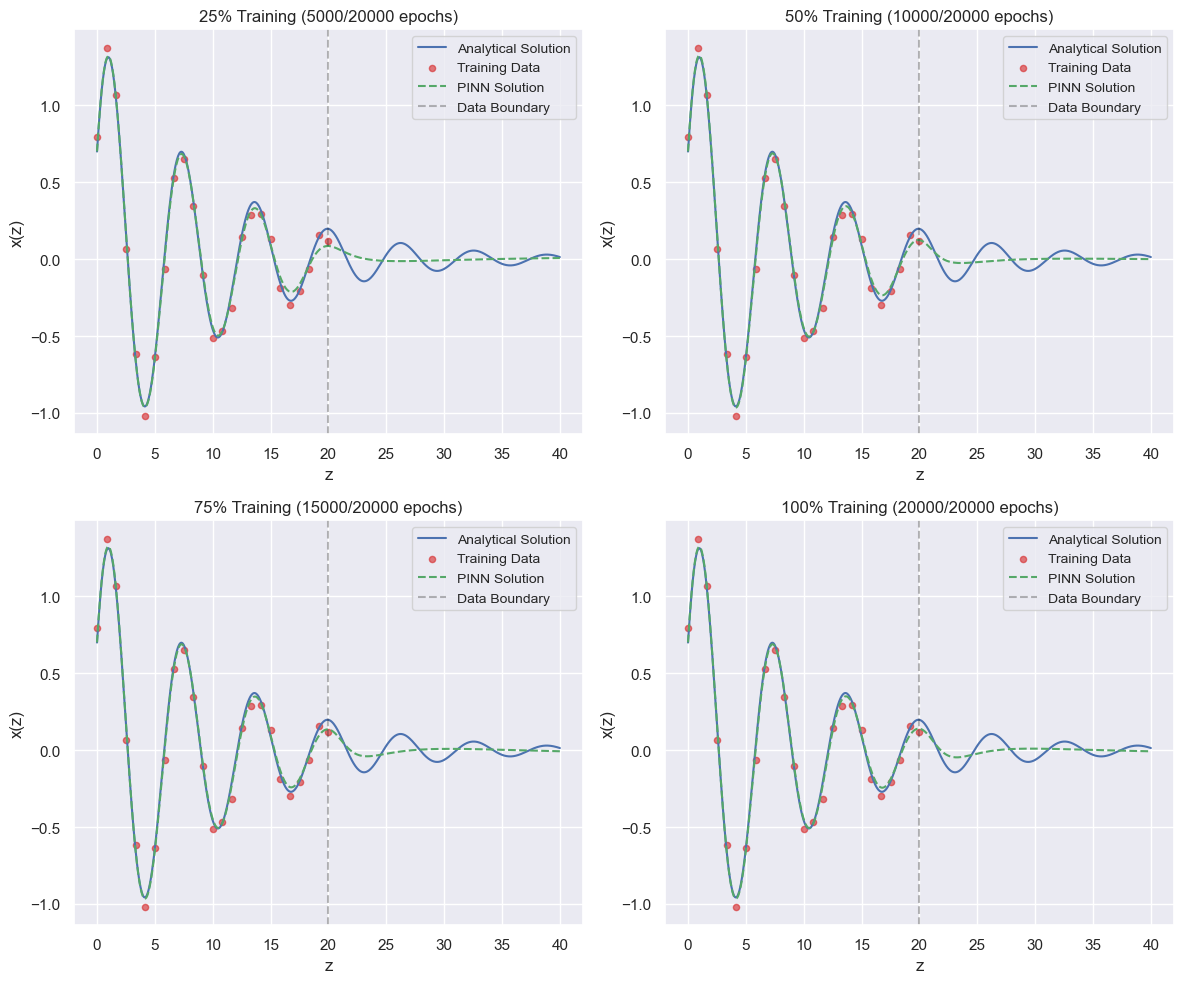

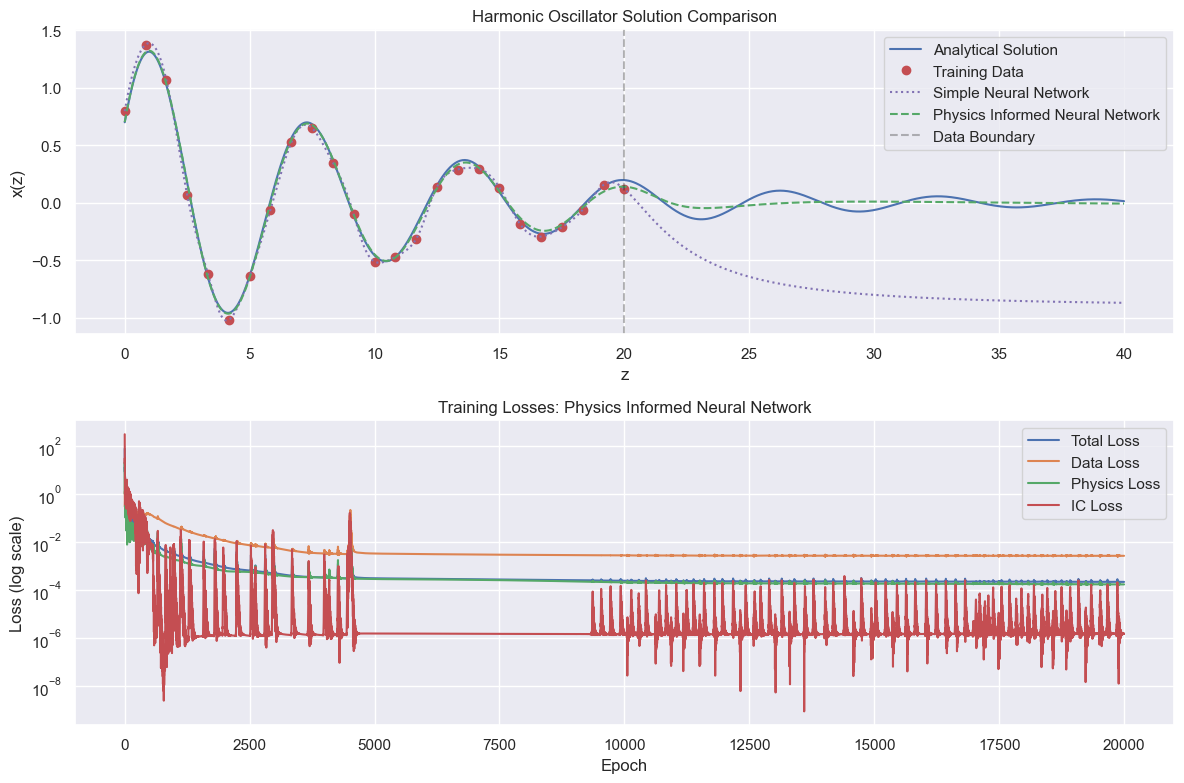

In [8]:
# Training parameters
INPUT_DIM = 1
OUTPUT_DIM = 1
HIDDEN_UNITS = 64
NUM_EPOCHS = 20000
LEARNING_RATE = 1e-3

# Create and train the model
simple_pinn = PINN(INPUT_DIM, OUTPUT_DIM, HIDDEN_UNITS).to(device)
history = train_model(
    simple_pinn, 
    datapoints_z,
    datapoints_x, 
    zeta=zeta,  # Use your existing Xi value
    X_0=X_0,  # Initial position 
    V_0=V_0,  # Initial velocity
    lr=LEARNING_RATE, 
    num_epochs=NUM_EPOCHS,
    data_weight=0.05,
    physics_weight=0.50,
    ic_weight=0.25
)

# Evaluate and plot results
z_eval = torch.linspace(0, 40, 800).reshape(-1, 1).to(device)
predictions_simple_pinn = simple_pinn(z_eval).detach().cpu().numpy()

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(z.numpy(), x_analytical.numpy(), 'b-', label='Analytical Solution')
plt.plot(datapoints_z.numpy(), datapoints_x.numpy(), 'ro', label='Training Data')
plt.plot(z_eval.cpu().numpy(), predictions, 'm:', label='Simple Neural Network')
plt.plot(z_eval.cpu().numpy(), predictions_simple_pinn, 'g--', label='Physics Informed Neural Network')
plt.axvline(x=20, color='k', linestyle='--', alpha=0.3, label='Data Boundary')
plt.legend()
plt.title('Harmonic Oscillator Solution Comparison')
plt.xlabel('z')
plt.ylabel('x(z)')

plt.subplot(2, 1, 2)
plt.semilogy(history['total_loss'], label='Total Loss')
plt.semilogy(history['data_loss'], label='Data Loss')
plt.semilogy(history['physics_loss'], label='Physics Loss')
plt.semilogy(history['ic_loss'], label='IC Loss')
plt.legend()
plt.title('Training Losses: Physics Informed Neural Network')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.tight_layout()

## (5) Different Training Strategy

Here we try experimenting with our model by pre-training the model without the physics-loss to make it learn underlying patterns in the data and consequently introducing physics-loss during training to refine the model further using physics based information. Now, we could have set `data_weight=0` and made the training completely physics-based however, that would've resulted in our receeding from the data point

Training: 100%|██████████| 20000/20000 [01:27<00:00, 227.43epoch/s, total=0.00000, data=0.00000, phys=0.15905, ic=0.15609]  


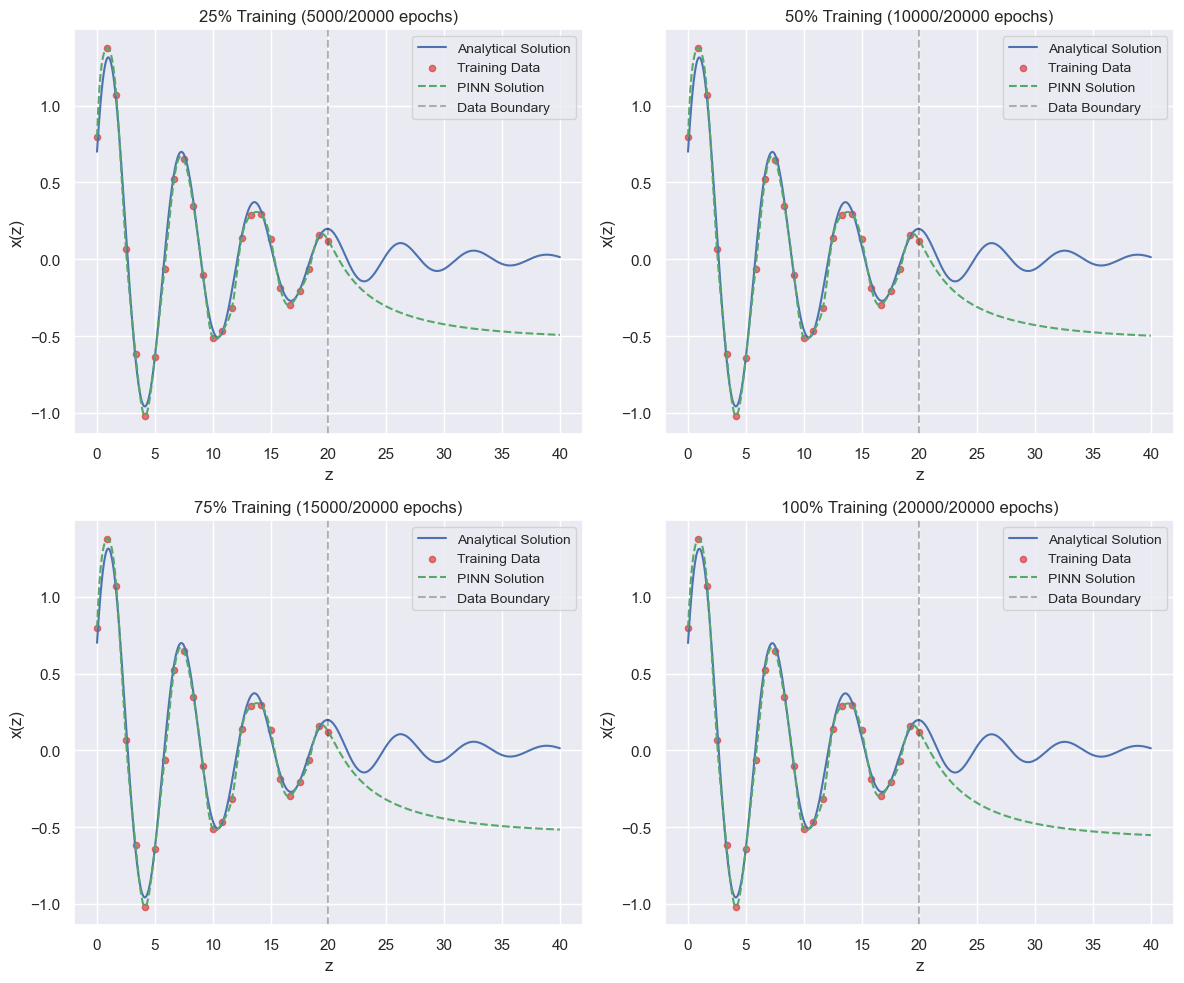

Training: 100%|██████████| 20000/20000 [01:31<00:00, 218.65epoch/s, total=0.00018, data=0.00257, phys=0.00010, ic=0.00000]


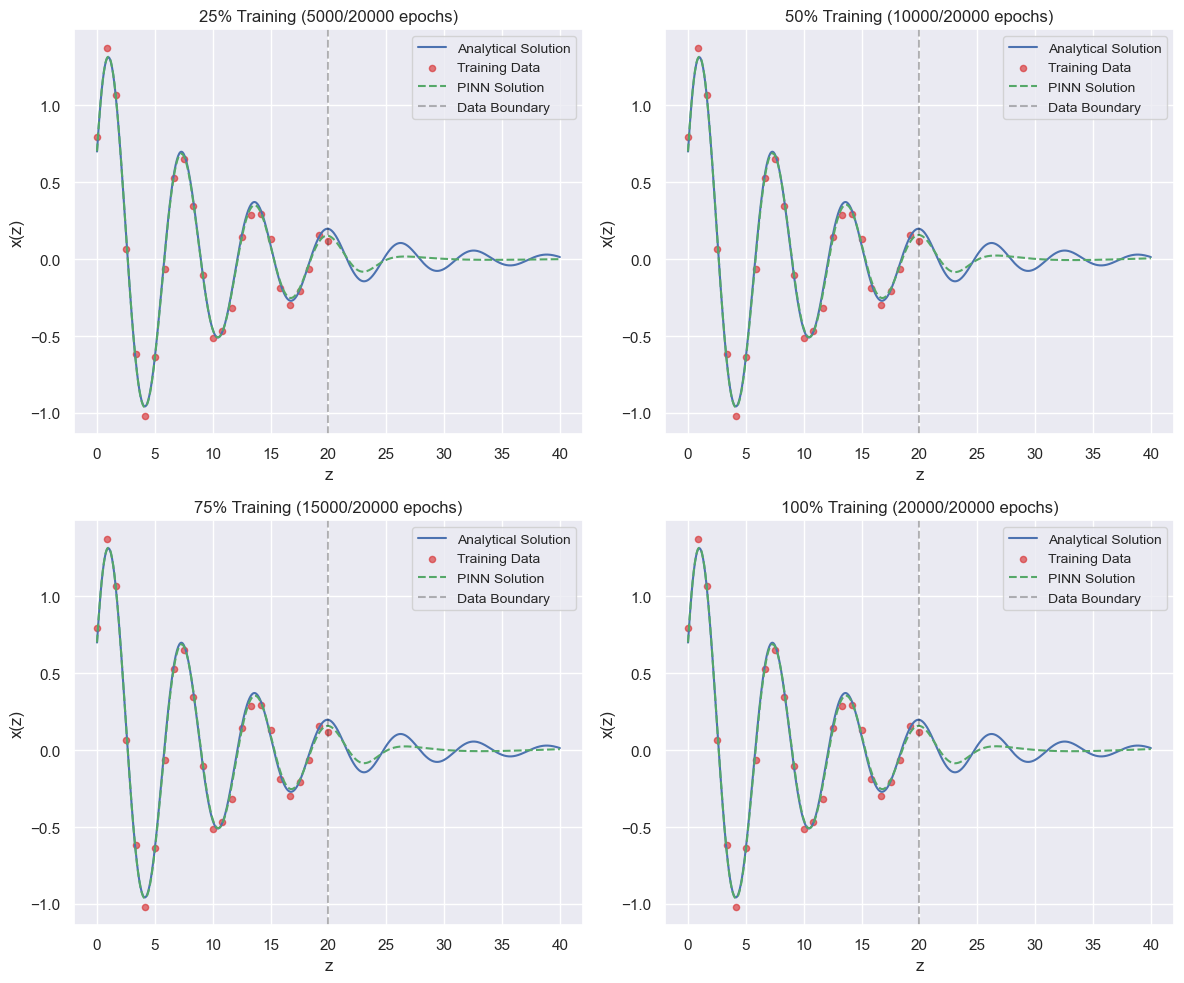

Text(0, 0.5, 'x(z)')

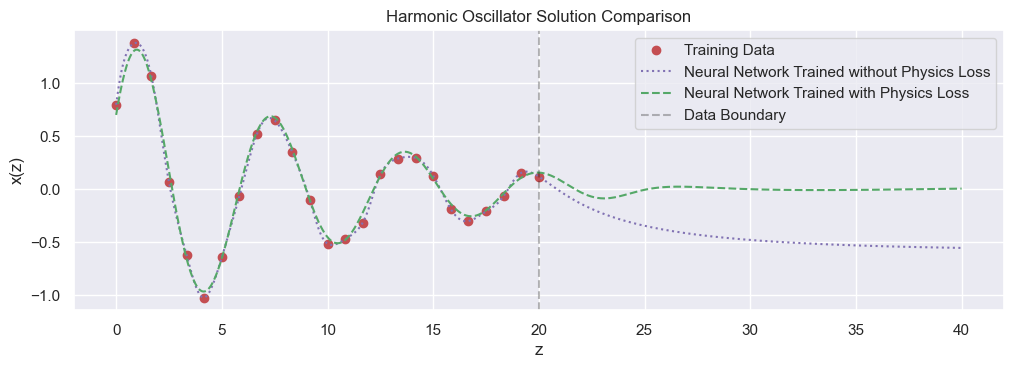

In [9]:
# Create and train the model
first_NN_then_PINN = PINN(INPUT_DIM, OUTPUT_DIM, HIDDEN_UNITS).to(device)
history = train_model(
    first_NN_then_PINN, 
    datapoints_z, 
    datapoints_x, 
    zeta=zeta,  # Use your existing Xi value
    X_0=X_0,  # Initial position 
    V_0=V_0,  # Initial velocity
    lr=LEARNING_RATE, 
    num_epochs=NUM_EPOCHS,
    physics_weight=0,
    ic_weight=0
)

# Evaluate and plot results
z_eval = torch.linspace(0, 40, 800).reshape(-1, 1).to(device)
pred_before_physics = first_NN_then_PINN(z_eval).detach().cpu().numpy()

# Create and train the model
simple_pinn = PINN(INPUT_DIM, OUTPUT_DIM, HIDDEN_UNITS)
history = train_model(
    first_NN_then_PINN, 
    datapoints_z, 
    datapoints_x, 
    zeta=zeta,  # Use your existing Xi value
    X_0=X_0,  # Initial position 
    V_0=V_0,  # Initial velocity
    lr=LEARNING_RATE, 
    num_epochs=NUM_EPOCHS,
    data_weight=0.05,
    physics_weight=0.50,
    ic_weight=0.25
)

z_eval = torch.linspace(0, 40, 800).reshape(-1, 1).to(device)
pred_after_physics = first_NN_then_PINN(z_eval).detach().cpu().numpy()


plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(datapoints_z.numpy(), datapoints_x.numpy(), 'ro', label='Training Data')
plt.plot(z_eval.cpu().numpy(), pred_before_physics, 'm:', label='Neural Network Trained without Physics Loss')
plt.plot(z_eval.cpu().numpy(), pred_after_physics, 'g--', label='Neural Network Trained with Physics Loss')
plt.axvline(x=20, color='k', linestyle='--', alpha=0.3, label='Data Boundary')
plt.legend()
plt.title('Harmonic Oscillator Solution Comparison')
plt.xlabel('z')
plt.ylabel('x(z)')

## (6) Reparameterization of Solution

In search of a better PINN based prediction I tried to reparametrize the solution in the following form,
$$
x(z) = \tau \, (z) \; + \; \sigma\,(z) \cdot f(z\,|\,\theta)
$$
where, \
$\tau\,(z)$ = a function which satisfies the boundary conditions \
$\sigma\,(z)$ = a function that is exaclty zero at the boundary condtions to avoid neural network predictions to interefere with the boundary conditions \
$f(z\,|\,\theta)$ = neural network model \

Here I have assumed,
$\tau\,(z) = x_0 + v_0 z$ and $\sigma\,(z) = z^2$

In [3]:
class ImprovedReparametrizedPINN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_units=[64, 128, 64],activation=nn.Softplus()):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        layers = []
        prev_units = input_dim
        for units in hidden_units:
            layers.append(nn.Linear(prev_units, units))
            layers.append(activation)
            prev_units = units
        layers.append(nn.Linear(prev_units, output_dim))
        self.layers = nn.Sequential(*layers)
        
        self._initialize_weights()

    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32).reshape(-1,self.input_dim).to(device)
        return self.layers(x)
    
    def trial_function(self, z, X_0, V_0):
        """
        Reparameterized solution:
            x_trial(z) = X_0 + V_0*z + z^2 * N(z,θ)
        This ensures x(0)=X_0 and x'(0)=V_0.
        """
        # z has grad enabled for derivative computation
        z_tensor = z.clone().requires_grad_(True).to(device)
        g = X_0 + V_0 * z_tensor
        A = z_tensor**2
        x_trial = g + A * self.forward(z_tensor)
        return x_trial
    
    def get_derivatives(self, x):
        """
        Computes the first and second derivatives for physics loss
        """
        x_tensor = x.clone().requires_grad_(True).to(device)
        y = self.trial_function(x_tensor, X_0, V_0)
        dy_dx = torch.autograd.grad(
            y, x_tensor,
            grad_outputs=torch.ones_like(y),
            create_graph=True,
            retain_graph=True
        )[0]
        dy2_dx2 = torch.autograd.grad(
            dy_dx, x_tensor,
            grad_outputs=torch.ones_like(dy_dx),
            create_graph=True,
            retain_graph=True
        )[0]
        return y, dy_dx, dy2_dx2

A new training function is defined for this model however we can see during and after the training that this method is unable to yield any satisfying result. The reason for why this model is unable to learn (as evident from plots during training) I'm unable to uncover as of now and needs further investigation

Training: 100%|██████████| 20000/20000 [03:49<00:00, 86.98epoch/s, total=0.38039, data=0.16213, phys=0.02183]            


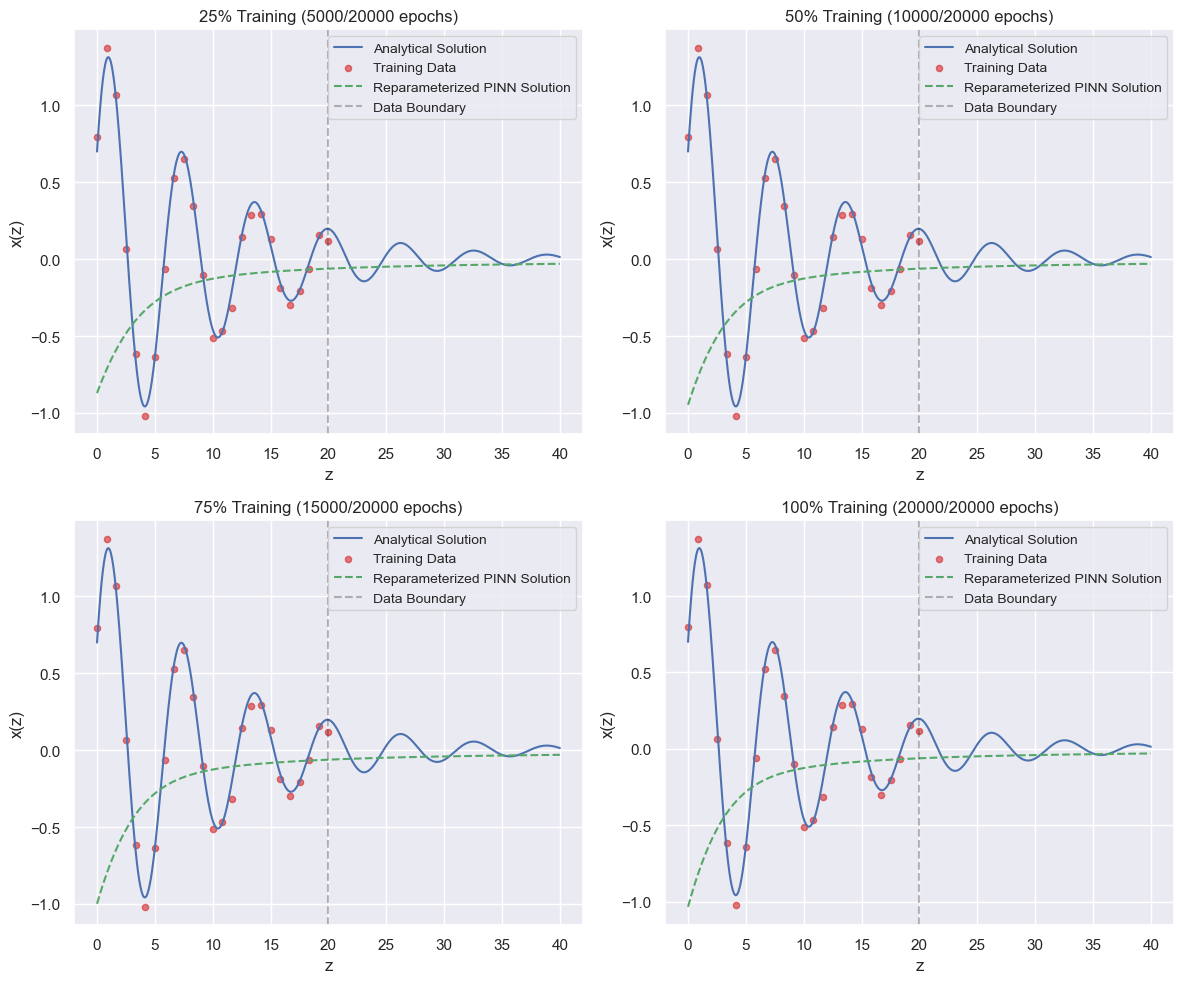

In [ ]:
def train_improvedPINN(
    model, 
    z_data, 
    x_data, 
    zeta, 
    X_0, 
    V_0, 
    num_epochs=20000,
    data_weight=1.0, 
    physics_weight=10.0,
    num_collocation_points=800, 
    domain=(0, 40), 
    lr=1e-3
):
    model = model.to(device)
    z_data = z_data.reshape(-1, 1).to(device)
    x_data = x_data.reshape(-1, 1).to(device)
    
    # Collocation points (for enforcing the ODE over the domain)
    z_collocation = torch.linspace(domain[0], domain[1], num_collocation_points).reshape(-1, 1).requires_grad_(True).to(device)
    z_eval = torch.linspace(domain[0], domain[1], 800).reshape(-1,1).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4, amsgrad=True)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode='min', 
            factor=0.5, 
            patience=200, 
            min_lr=1e-5, 
            verbose=True
        )
    
    mse_loss = nn.MSELoss()
    history = {
        'total_loss': [],
        'data_loss': [],
        'physics_loss': [],
    }

    progress_solutions = {}
    checkpoints = [int(num_epochs * p) for p in [0.25, 0.50, 0.75, 1.0]]
    
    with tqdm(range(num_epochs), desc="Training", unit="epoch") as pbar:
        for epoch in pbar:
            optimizer.zero_grad()

            # Data loss: fit the noisy training data
            x_trial_data = model.trial_function(z_data, X_0, V_0)
            data_loss = mse_loss(x_trial_data, x_data)

            # Physics loss: enforce the ODE x'' + 2*zeta*x' + x = 0 on collocation points
            x_collocation_trial, dx_dz, dx2_dz2 = model.get_derivatives(z_collocation)
            ode_residual = dx2_dz2 + 2 * zeta * dx_dz + x_collocation_trial
            physics_loss = torch.mean(ode_residual ** 2)

            # Total loss as a weighted sum
            total_loss = data_weight * data_loss + physics_weight * physics_loss
            total_loss.backward()

            # Clip gradients to improve stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
            optimizer.step()
            scheduler.step(total_loss)

            history['total_loss'].append(total_loss.item())
            history['data_loss'].append(data_loss.item())
            history['physics_loss'].append(physics_loss.item())

            pbar.set_postfix({
                'total': f'{total_loss.item():.5f}',
                'data': f'{data_loss.item():.5f}',
                'phys': f'{physics_loss.item():.5f}',
            })

            # Capture solutions at checkpoint epochs (25%, 50%, 75%, 100%)
            if epoch + 1 in checkpoints:
                progress_percentage = int(((epoch + 1) / num_epochs) * 100)
                
                # Get current model predictions
                model.eval()  # Set to evaluation mode
                with torch.no_grad():
                    predictions = model(z_eval).detach().cpu().numpy()
                model.train()  # Set back to training mode
                
                # Store the current solution
                progress_solutions[progress_percentage] = predictions.copy()

    plt.figure(figsize=(12,10))

    for i,percentage in enumerate([25, 50, 75, 100]):
        plt.subplot(2,2,i+1)

        try:
            plt.plot(z.numpy(), x_analytical.numpy(), 'b-', label='Analytical Solution')
        except NameError:
            pass

        plt.scatter(z_data.cpu().detach().numpy(), x_data.cpu().detach().numpy(), 
                    color="tab:red", s=20, alpha=0.6, label='Training Data')
        
        # Plot PINN prediction at this stage
        plt.plot(z_eval.cpu().numpy(), progress_solutions[percentage], 'g--', label='Reparameterized PINN Solution')
        
        plt.axvline(x=20, color='k', linestyle='--', alpha=0.3, label='Data Boundary')
        plt.title(f'{percentage}% Training ({int(percentage*num_epochs/100)}/{num_epochs} epochs)')
        plt.xlabel('z')
        plt.ylabel('x(z)')
        plt.legend(loc='upper right', fontsize='small')

    plt.tight_layout()
    
    return history

improved_pinn = ImprovedReparametrizedPINN(input_dim=1, output_dim=1, hidden_units=[64, 128, 64])
history = train_improvedPINN(
    improved_pinn, 
    datapoints_z, 
    datapoints_x, 
    zeta=zeta,  
    X_0=X_0,  
    V_0=V_0,
    lr=1e-3, 
    num_epochs=20000,
    data_weight=1.0,
    physics_weight=10.0,
    num_collocation_points=1000,
    domain=(0, 40)
)

# Evaluate and plot results
z_eval = torch.linspace(0, 40, 800).reshape(-1, 1).to(device)
pred_repara_pinn = improved_pinn(z_eval).detach().cpu().numpy()

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(z.numpy(), x_analytical.numpy(), 'b-', label='Analytical Solution')
plt.plot(datapoints_z.numpy(), datapoints_x.numpy(), 'ro', label='Training Data')
plt.plot(z_eval.cpu().numpy(), pred_repara_pinn, 'g--', label='Reparameterized PINN')
plt.axvline(x=20, color='k', linestyle='--', alpha=0.3, label='Data Boundary')
plt.legend()
plt.title('Harmonic Oscillator Solution Comparison')
plt.xlabel('z')
plt.ylabel('x(z)')

plt.subplot(2, 1, 2)
plt.semilogy(history['total_loss'], label='Total Loss')
plt.semilogy(history['data_loss'], label='Data Loss')
plt.semilogy(history['physics_loss'], label='Physics Loss')
plt.legend()
plt.title('Training Losses: Reparameterized Physics Informed Neural Network')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.tight_layout()

## Evaluation of trained PINN

Finally we move on to evaluating the models, and for this we test the models on two parameters,
1. **Derivatives comparison**: so far we have seen how well and close the model is able to map the x(z) solution. Now we will see how close the derivatives (which signify physical terms like velocity and acceleration) of solution given by our model are in comparison to the analytical solution. Here we plot the following 3 graphs,

    (i). $\quad x(z) \quad vs \quad z,\quad$ for model solution and analytical solution \
    (ii). $\quad \frac{d}{dz}f(z\,|\,\theta) \quad vs \quad z, \quad$ for model solution and analytical solution \
    (iii). $\quad \frac{d^2}{dz^2}f(z\,|\,\theta) \quad vs \quad z, \quad$ for model solution and analytical solution

3. **Energy Analysis**: here we examine how different energy forms like kinetic and potential energy vary in comparison and also how well solution of our model is able to uphold the conservation laws. Here we plot the following 4 graphs,

    (i). Kinetic Energy $\quad vs \quad z$\
    (ii). Potential Energy $\quad vs \quad z$ \
    (iii). Total Energy $\quad vs \quad z$ \
    (iv). Energy Decay $\quad vs \quad z$

In [10]:
def grad(outputs, inputs):
    """
    Compute the partial derivative of an output wrt input
    Args:
        outputs: dependent variable
        inputs: independent variable
    """
    return torch.autograd.grad(
        outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True
    )[0]

def compare_model_derivatives(
        model, 
        model_name,
        zeta, 
        domain=(0,40), 
        num_points=1000, 
        analytical_soln=eqn
    ):

    z_eval = torch.linspace(domain[0], domain[1], num_points, requires_grad=True).reshape(-1,1)
    x_analytical = analytical_soln(z_eval)

    model.eval()
    with torch.no_grad():
        x_pred, dx_dz_pred, d2x_dz2_pred = model.get_derivatives(z_eval)
    
    fig, axes = plt.subplots(3,1, figsize=(18,14))

    axes[0].plot(z_eval.clone().detach().cpu().numpy(), x_pred.clone().detach().cpu().numpy(),'b-', label=f'{model_name} Solution')
    axes[0].plot(z_eval.clone().detach().cpu().numpy(), x_analytical.clone().detach().cpu().numpy(), 'k:', label='Analytical Solution')
    axes[0].set_ylabel('Position x(z)')
    axes[0].set_title('Solution Comparison')
    axes[0].legend()
    axes[0].grid(True, alpha=0.7)
    
    ## first derivative
    dx_dz_analytical = grad(x_analytical, z_eval)
    axes[1].plot(z_eval.clone().detach().cpu().numpy(), dx_dz_pred.clone().detach().cpu().numpy(), 'b-', label=f'{model_name} dx/dz')
    axes[1].plot(z_eval.clone().detach().cpu().numpy(), dx_dz_analytical.clone().detach().cpu().numpy(), 'k:', label='Analytical dx/dz')
    axes[1].set_ylabel('Velocity dx/dz')
    axes[1].set_title('First Derivative Comparison')
    axes[1].legend()
    axes[1].grid(True, alpha=0.7)

    ## second derivative
    d2x_dz2_analytical = grad(dx_dz_analytical, z_eval)
    axes[2].plot(z_eval.clone().detach().cpu().numpy(), d2x_dz2_pred.clone().detach().cpu().numpy(), 'b-', label=f'{model_name} d2x/dz2')
    axes[2].plot(z_eval.clone().detach().cpu().numpy(), d2x_dz2_analytical.clone().detach().cpu().numpy(), 'k:', label='Analytical d2x/dz2')
    axes[2].set_xlabel('z')
    axes[2].set_ylabel('Acceleration d²x/dz²')
    axes[2].set_title('Second Derivative Comparison')
    axes[2].legend()
    axes[2].grid(True, alpha=0.7)

    fig.suptitle(f'Derivatives Comparison for Harmonic Oscillator (ζ = {zeta})', fontsize=16)

    plt.tight_layout()
    
    ## Energy Analysis
    fig, axes = plt.subplots(2,2, figsize=(18,10))
    axes = axes.flatten()

    # calculate energy for analytical
    KE_analytical = 0.5 * dx_dz_analytical**2 # KE = 1/2*m*(v**2)
    PE_analytical = 0.5 * x_analytical**2 # PE = 1/2 * k * (x**2)
    TE_analytical = KE_analytical + PE_analytical

    # calculate energy decay due to damping
    energy_decay = torch.exp(-2 * zeta * z_eval)
    expected_TE = TE_analytical[0] * energy_decay

    axes[3].plot(z_eval.clone().detach().cpu().numpy(), expected_TE.clone().detach().cpu().numpy(), 'k--', label="Expected Decay")

    # calculate energy based on model predictions
    KE_model = 0.5 * dx_dz_pred**2
    PE_model = 0.5 * x_pred**2
    TE_model = KE_model + PE_model

    axes[0].plot(z_eval.clone().detach().cpu().numpy(), KE_model.clone().detach().cpu().numpy(), 'b-', label=f'{model_name} Kinetic Energy')
    axes[0].plot(z_eval.clone().detach().cpu().numpy(), KE_analytical.clone().detach().cpu().numpy(), 'k:', label=f'Analytical Kinetic Energy')
    axes[0].set_title('Kinetic Energy (0.5 * (dx/dz)²)')
    axes[0].set_ylabel('Energy')
    axes[0].set_xlabel('z')
    axes[0].legend()
    axes[0].grid(True, alpha=0.7)

    axes[1].plot(z_eval.clone().detach().cpu().numpy(), PE_model.clone().detach().cpu().numpy(), 'b-', label=f'{model_name} Potential Energy')
    axes[1].plot(z_eval.clone().detach().cpu().numpy(), PE_analytical.clone().detach().cpu().numpy(), 'k:', label=f'Analytical Potential Energy')
    axes[1].set_title('Potential Energy (0.5 * x²)')
    axes[1].set_ylabel('Energy')
    axes[1].set_xlabel('z')
    axes[1].legend()
    axes[1].grid(True, alpha=0.7)

    axes[2].plot(z_eval.clone().detach().cpu().numpy(), TE_model.clone().detach().cpu().numpy(), 'b-', label=f'{model_name} Potential Energy')
    axes[2].plot(z_eval.clone().detach().cpu().numpy(), TE_analytical.clone().detach().cpu().numpy(), 'k:', label=f'Analytical Potential Energy')
    axes[2].set_title('Total Energy (KE + PE)')
    axes[2].set_ylabel('Energy')
    axes[2].set_xlabel('z')
    axes[2].legend()
    axes[2].grid(True, alpha=0.7)

    axes[3].plot(z_eval.clone().detach().cpu().numpy(), (TE_model/TE_model[0]).clone().detach().cpu().numpy(), 'b-', label=f'{model_name}')
    axes[3].plot(z_eval.clone().detach().cpu().numpy(), (TE_analytical/TE_analytical[0]).clone().detach().cpu().numpy(), 'k:', label=f'Analytical')
    axes[3].set_title('Normalized Total Energy')
    axes[3].set_ylabel('Energy Ratio (E/E[0])')
    axes[3].set_xlabel('z')
    axes[3].set_yscale('log')
    axes[3].legend()
    axes[3].grid(True, alpha=0.7)

    fig.suptitle(f'Energy Analysis for Damped Oscillator (ζ = {zeta})', fontsize=16)

    plt.tight_layout()

#### (i). Simple Neural Network

We start off with a simple neural network trained on data points for $z \in [0,20]$. We can make the following observations based on the graphs we have plotted below,

**Derivatives Comparison**,
1. we see that the neural network solution has tried best to fit the data points but outside it's training domain the model just wanders off from the solution due to lack of information
2. for $\frac{d}{dz}f(z\,|\,\theta)$ we see disturbance in the curve and the model deviates from the analytical first derivative of the solution
3. for $\frac{d^2}{dz^2}f(z\,|\,\theta)$ there is too much disturbance with more frequent rise and fall in the curve

**Energy analysis**,
1. Kinetic energy shows very little noise just that the local maxima (or peaks) overshoots the local maxima of analytically derived curve and the curve flattens after $z=20$
2. Potential energy curve also overshoots for the intial two cycles and then it gets better however the curve shows growing undesired deviation after $z=20$
3. Total energy has some initial noise and the deviates after $z=20$
4. The energy decay follows a downtrend with little noise but then shows deviation after $z=20$

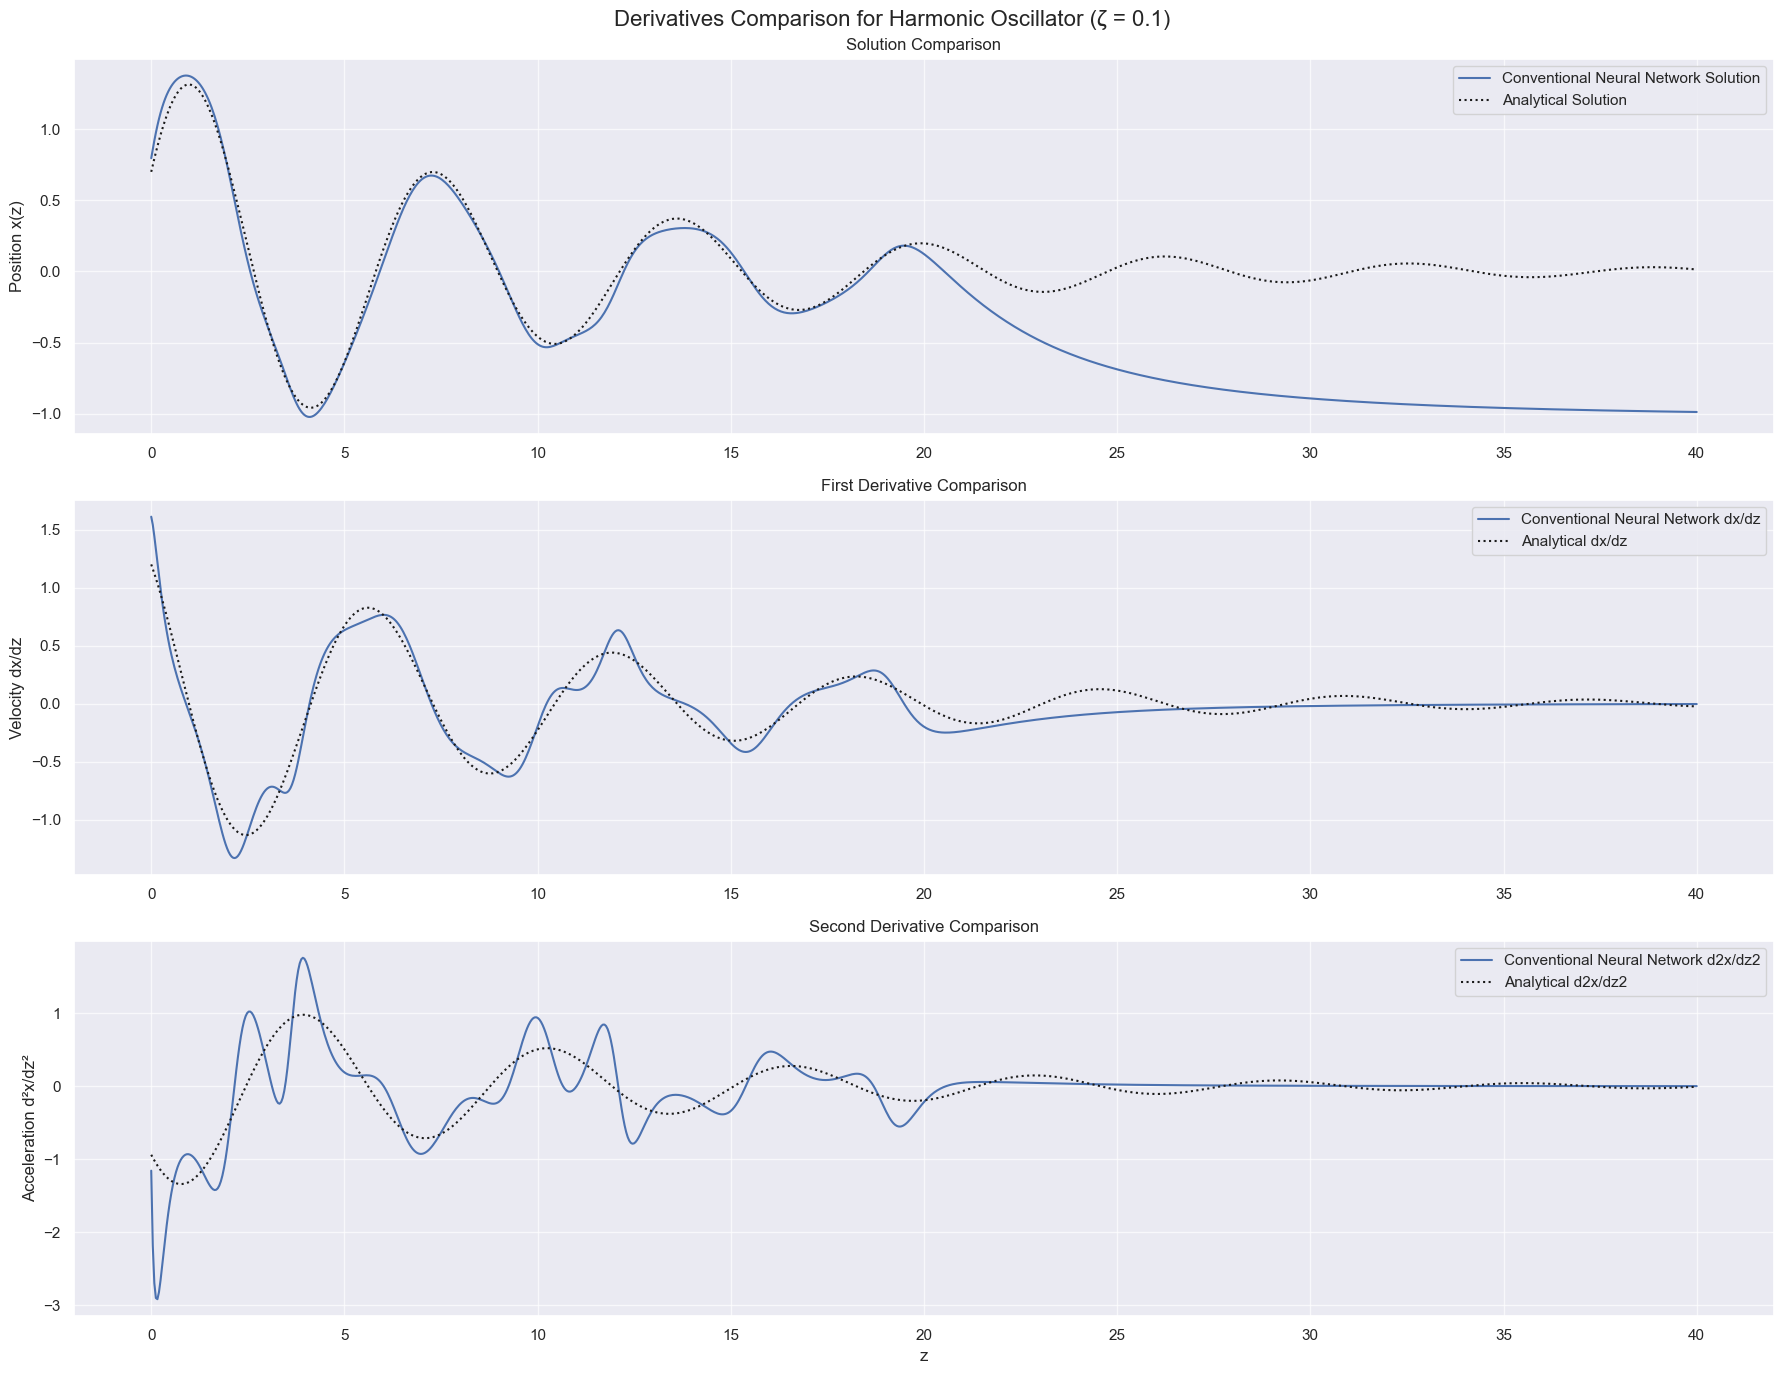

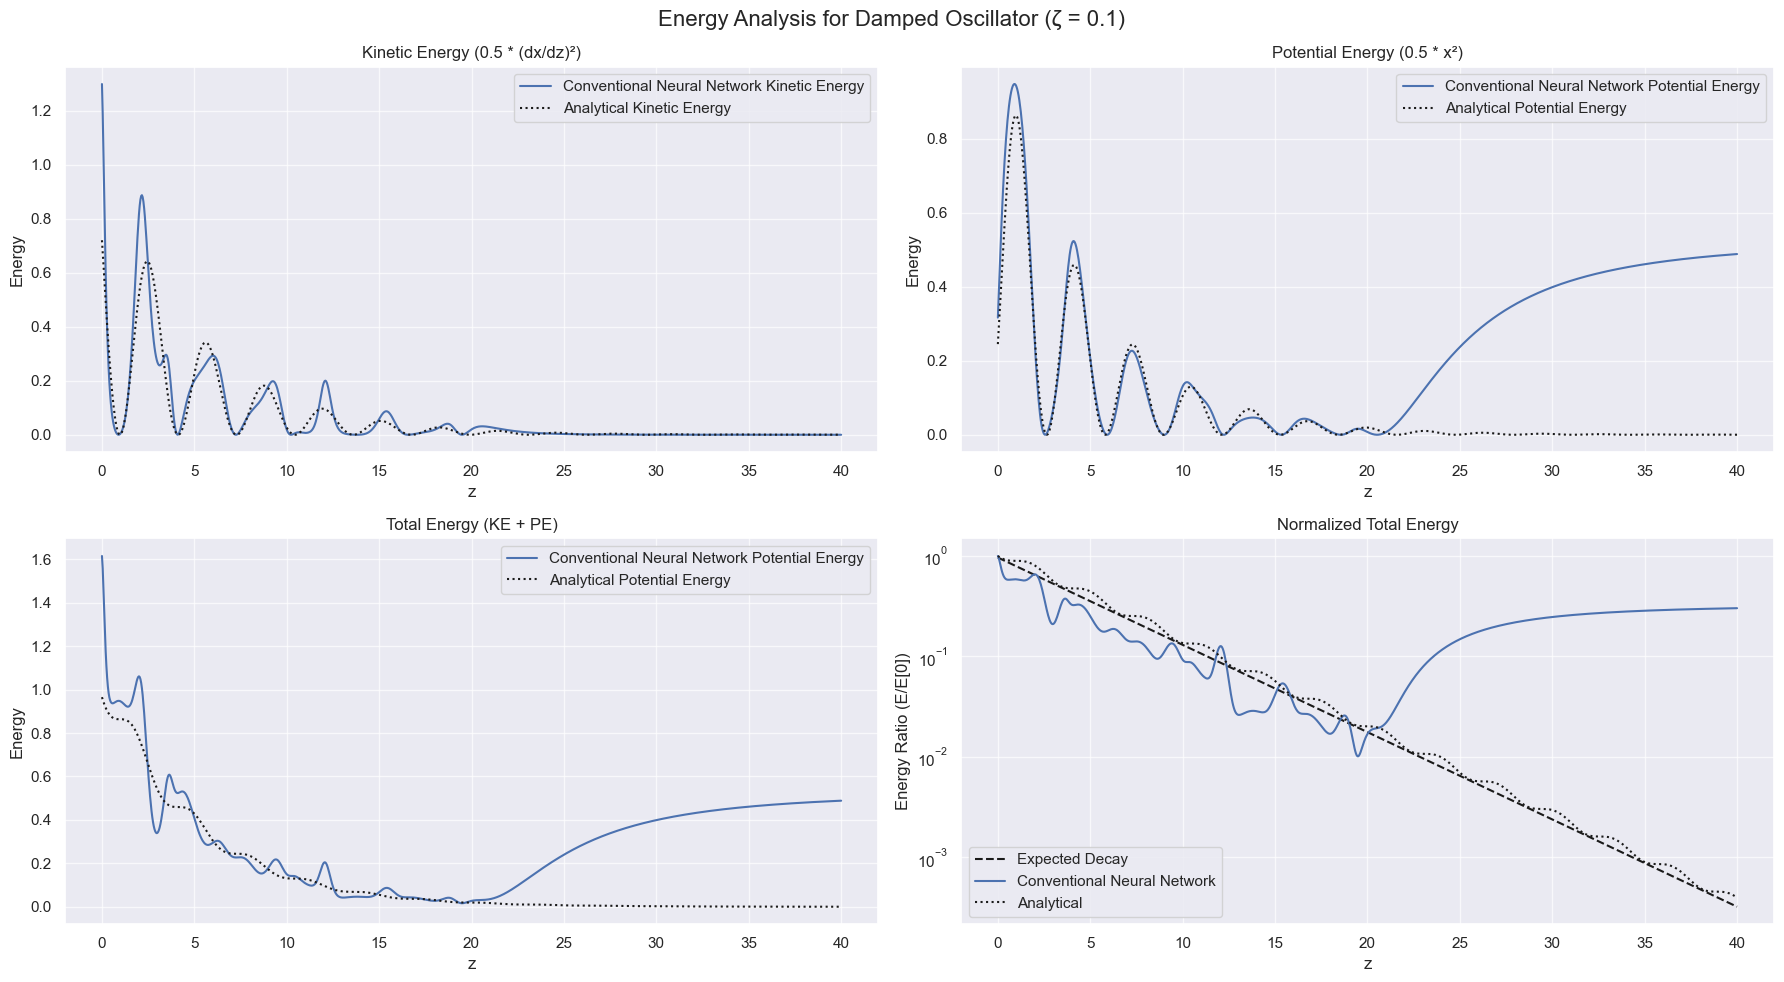

In [21]:
compare_model_derivatives(simple_nn, 'Conventional Neural Network', zeta)

#### (ii) Physics Informed Neural Network

In case of PINN, we observe that \
(i). Derivatives are more smooth with almost no noise and also doesn't deviate increasingly outside of the training domain \
(ii). Both kinetic and potential energy given by the model resemble the analytical values very closely. However, we can that energy decay starts deviating around the data boundary and drops more in an unexpected fashion 

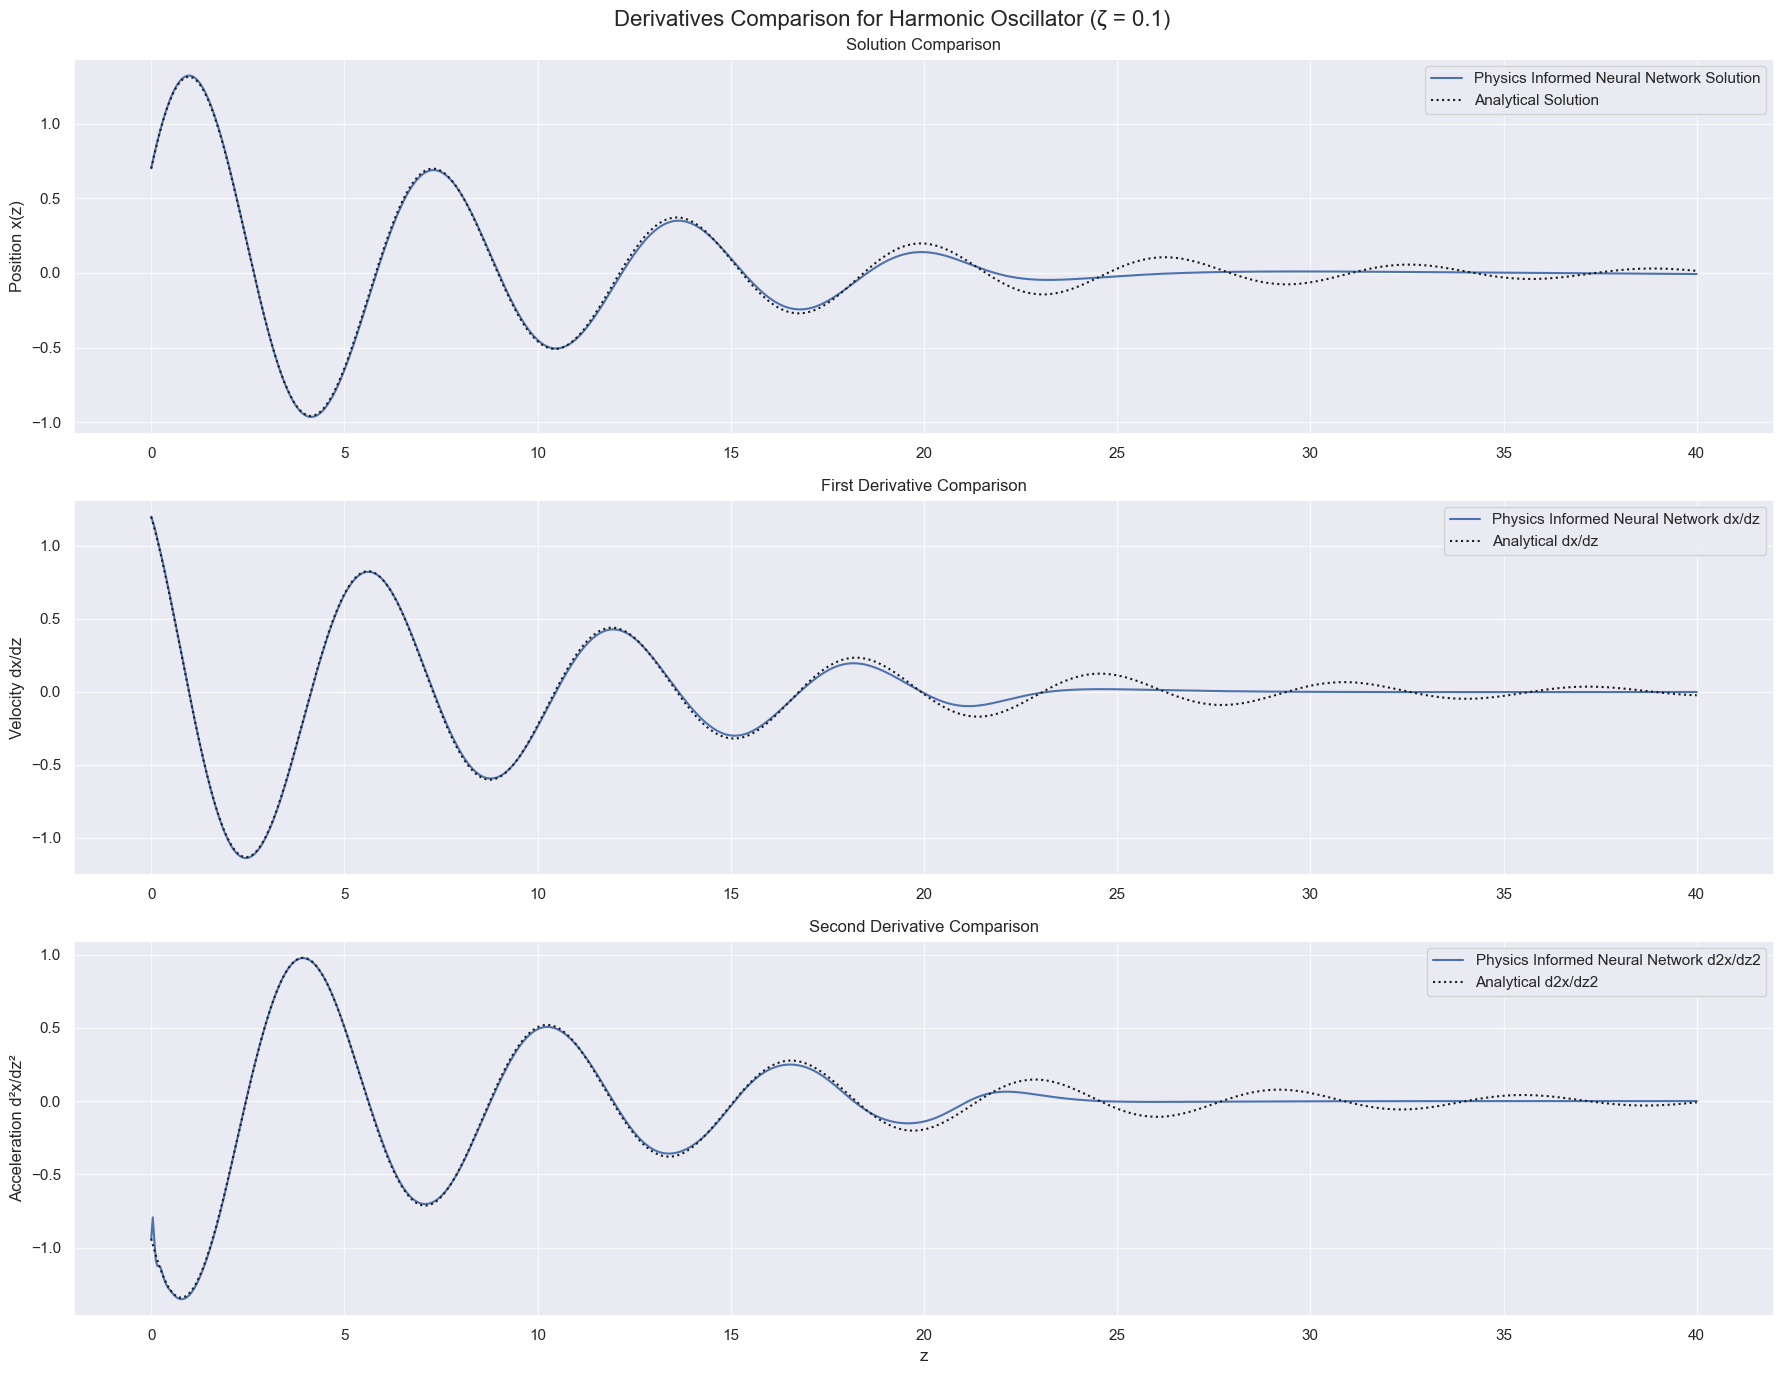

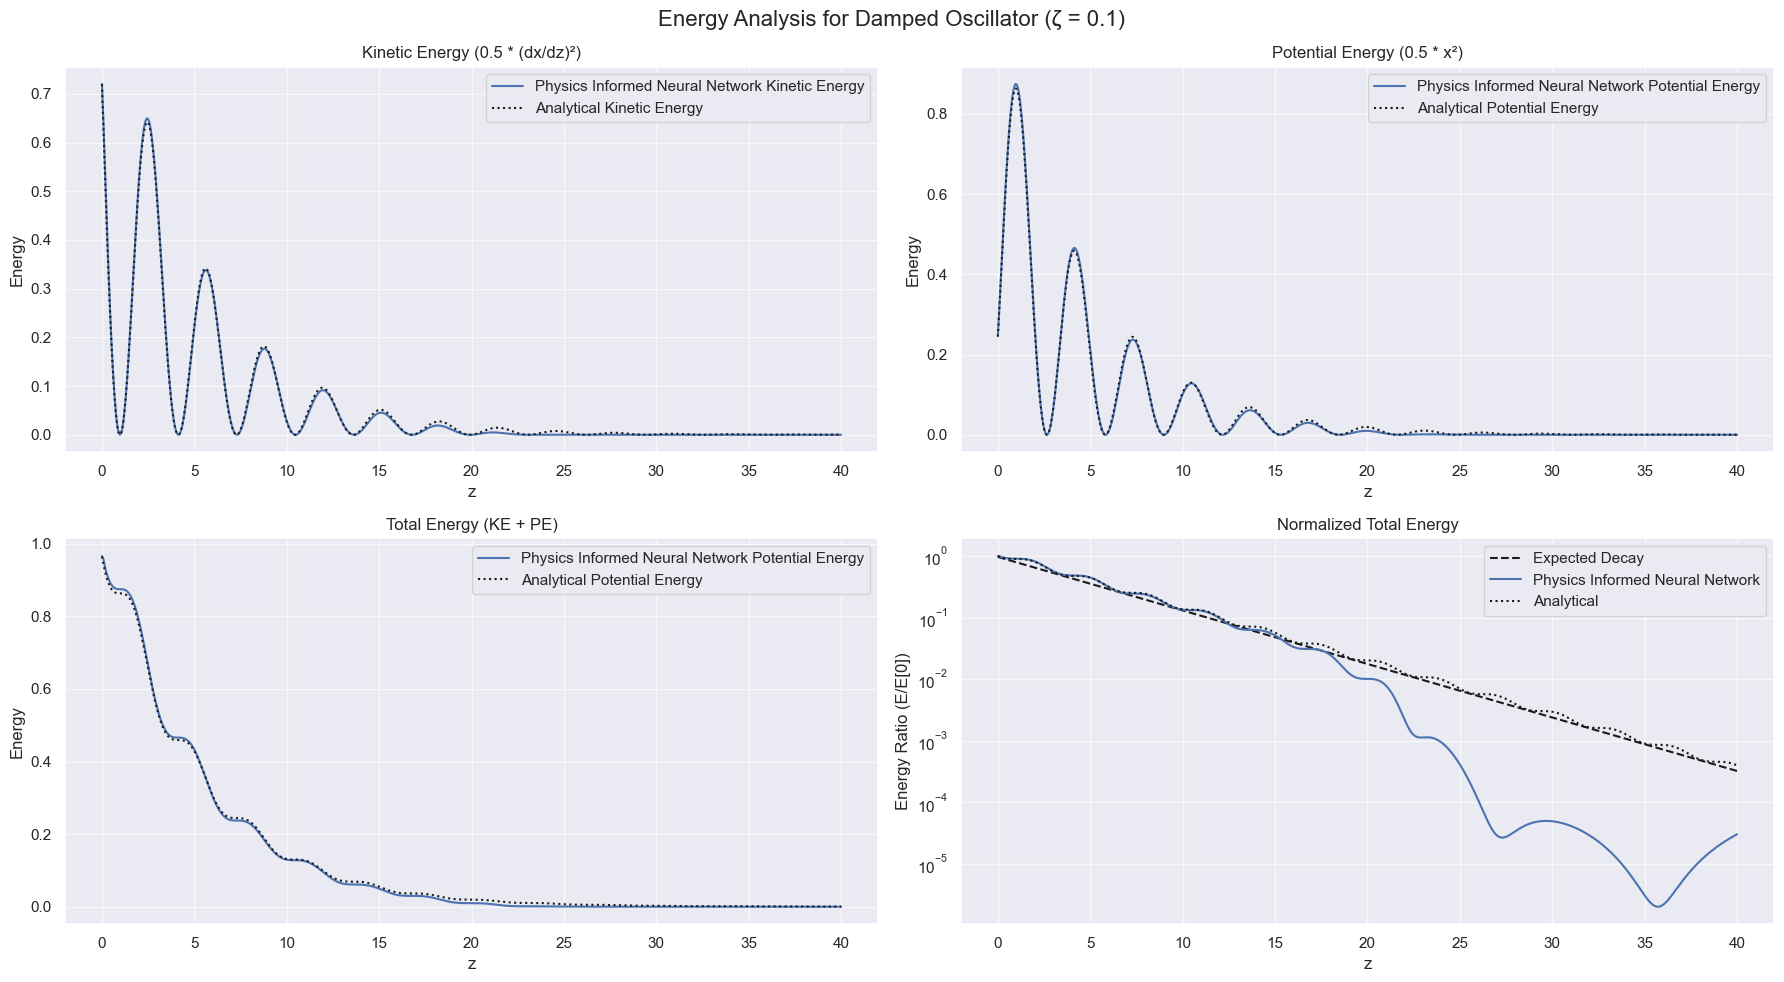

In [11]:
compare_model_derivatives(simple_pinn, 'Physics Informed Neural Network', zeta)

#### (iii). Pre-Trained PINN

In case of a Pre-Trained PINN, we can observe results very similar to that of a PINN without pre-training. However, we do see comparatively a more closer resemblance to the analytical solution both in terms of derivatives and energy which could be due to the model undergoing twice the number of training epochs due to the pre-training steps.

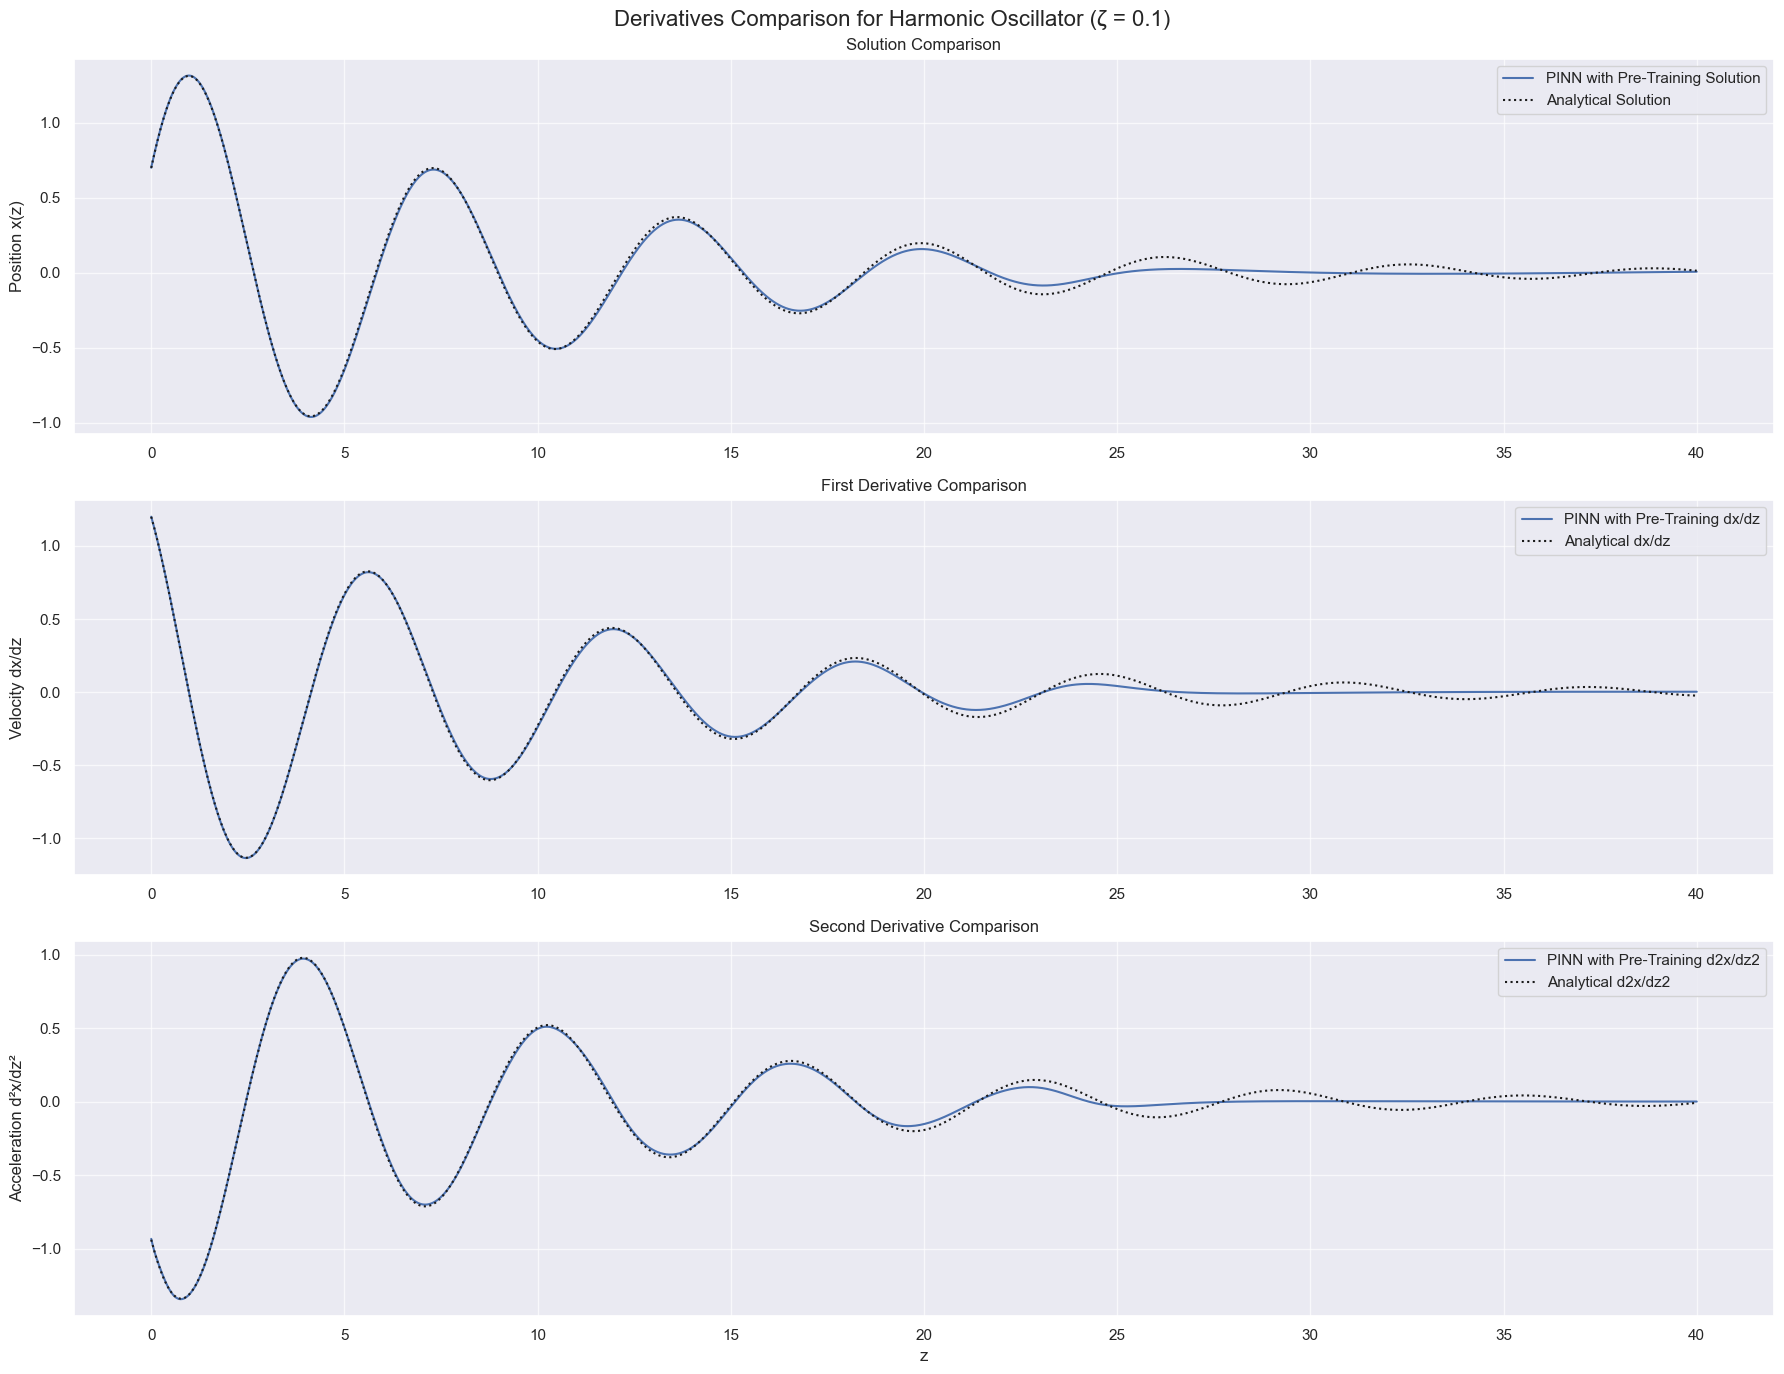

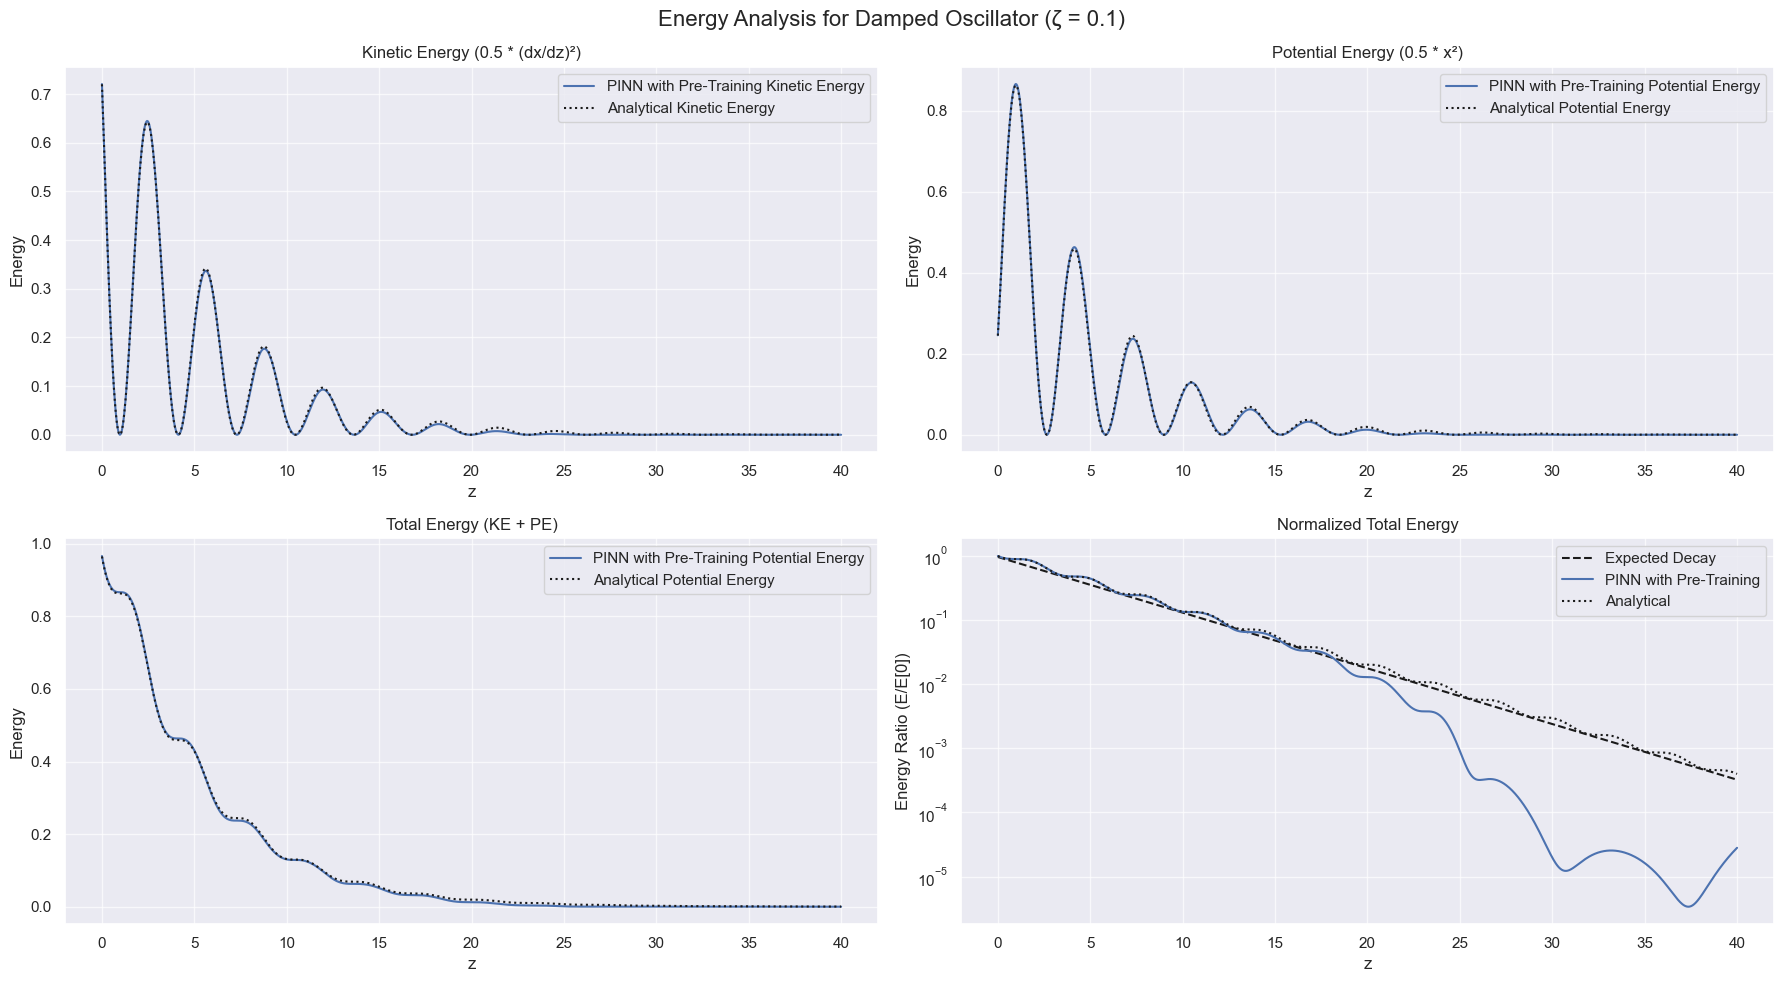

In [23]:
compare_model_derivatives(first_NN_then_PINN, "PINN with Pre-Training", zeta)

## Different zeta values

#### PINN for different zeta values

As the zeta values increases the damping of the motion increases. We also see that the PINN model chooses to stay close to the analytical solution for all the values of zeta which could be a good thing if there's too much noise in the data but not a good thing if our aim is to model a rather complex harmonic motion.

Training: 100%|██████████| 20000/20000 [01:32<00:00, 216.59epoch/s, total=0.00010, data=0.00180, phys=0.00002, ic=0.00000]


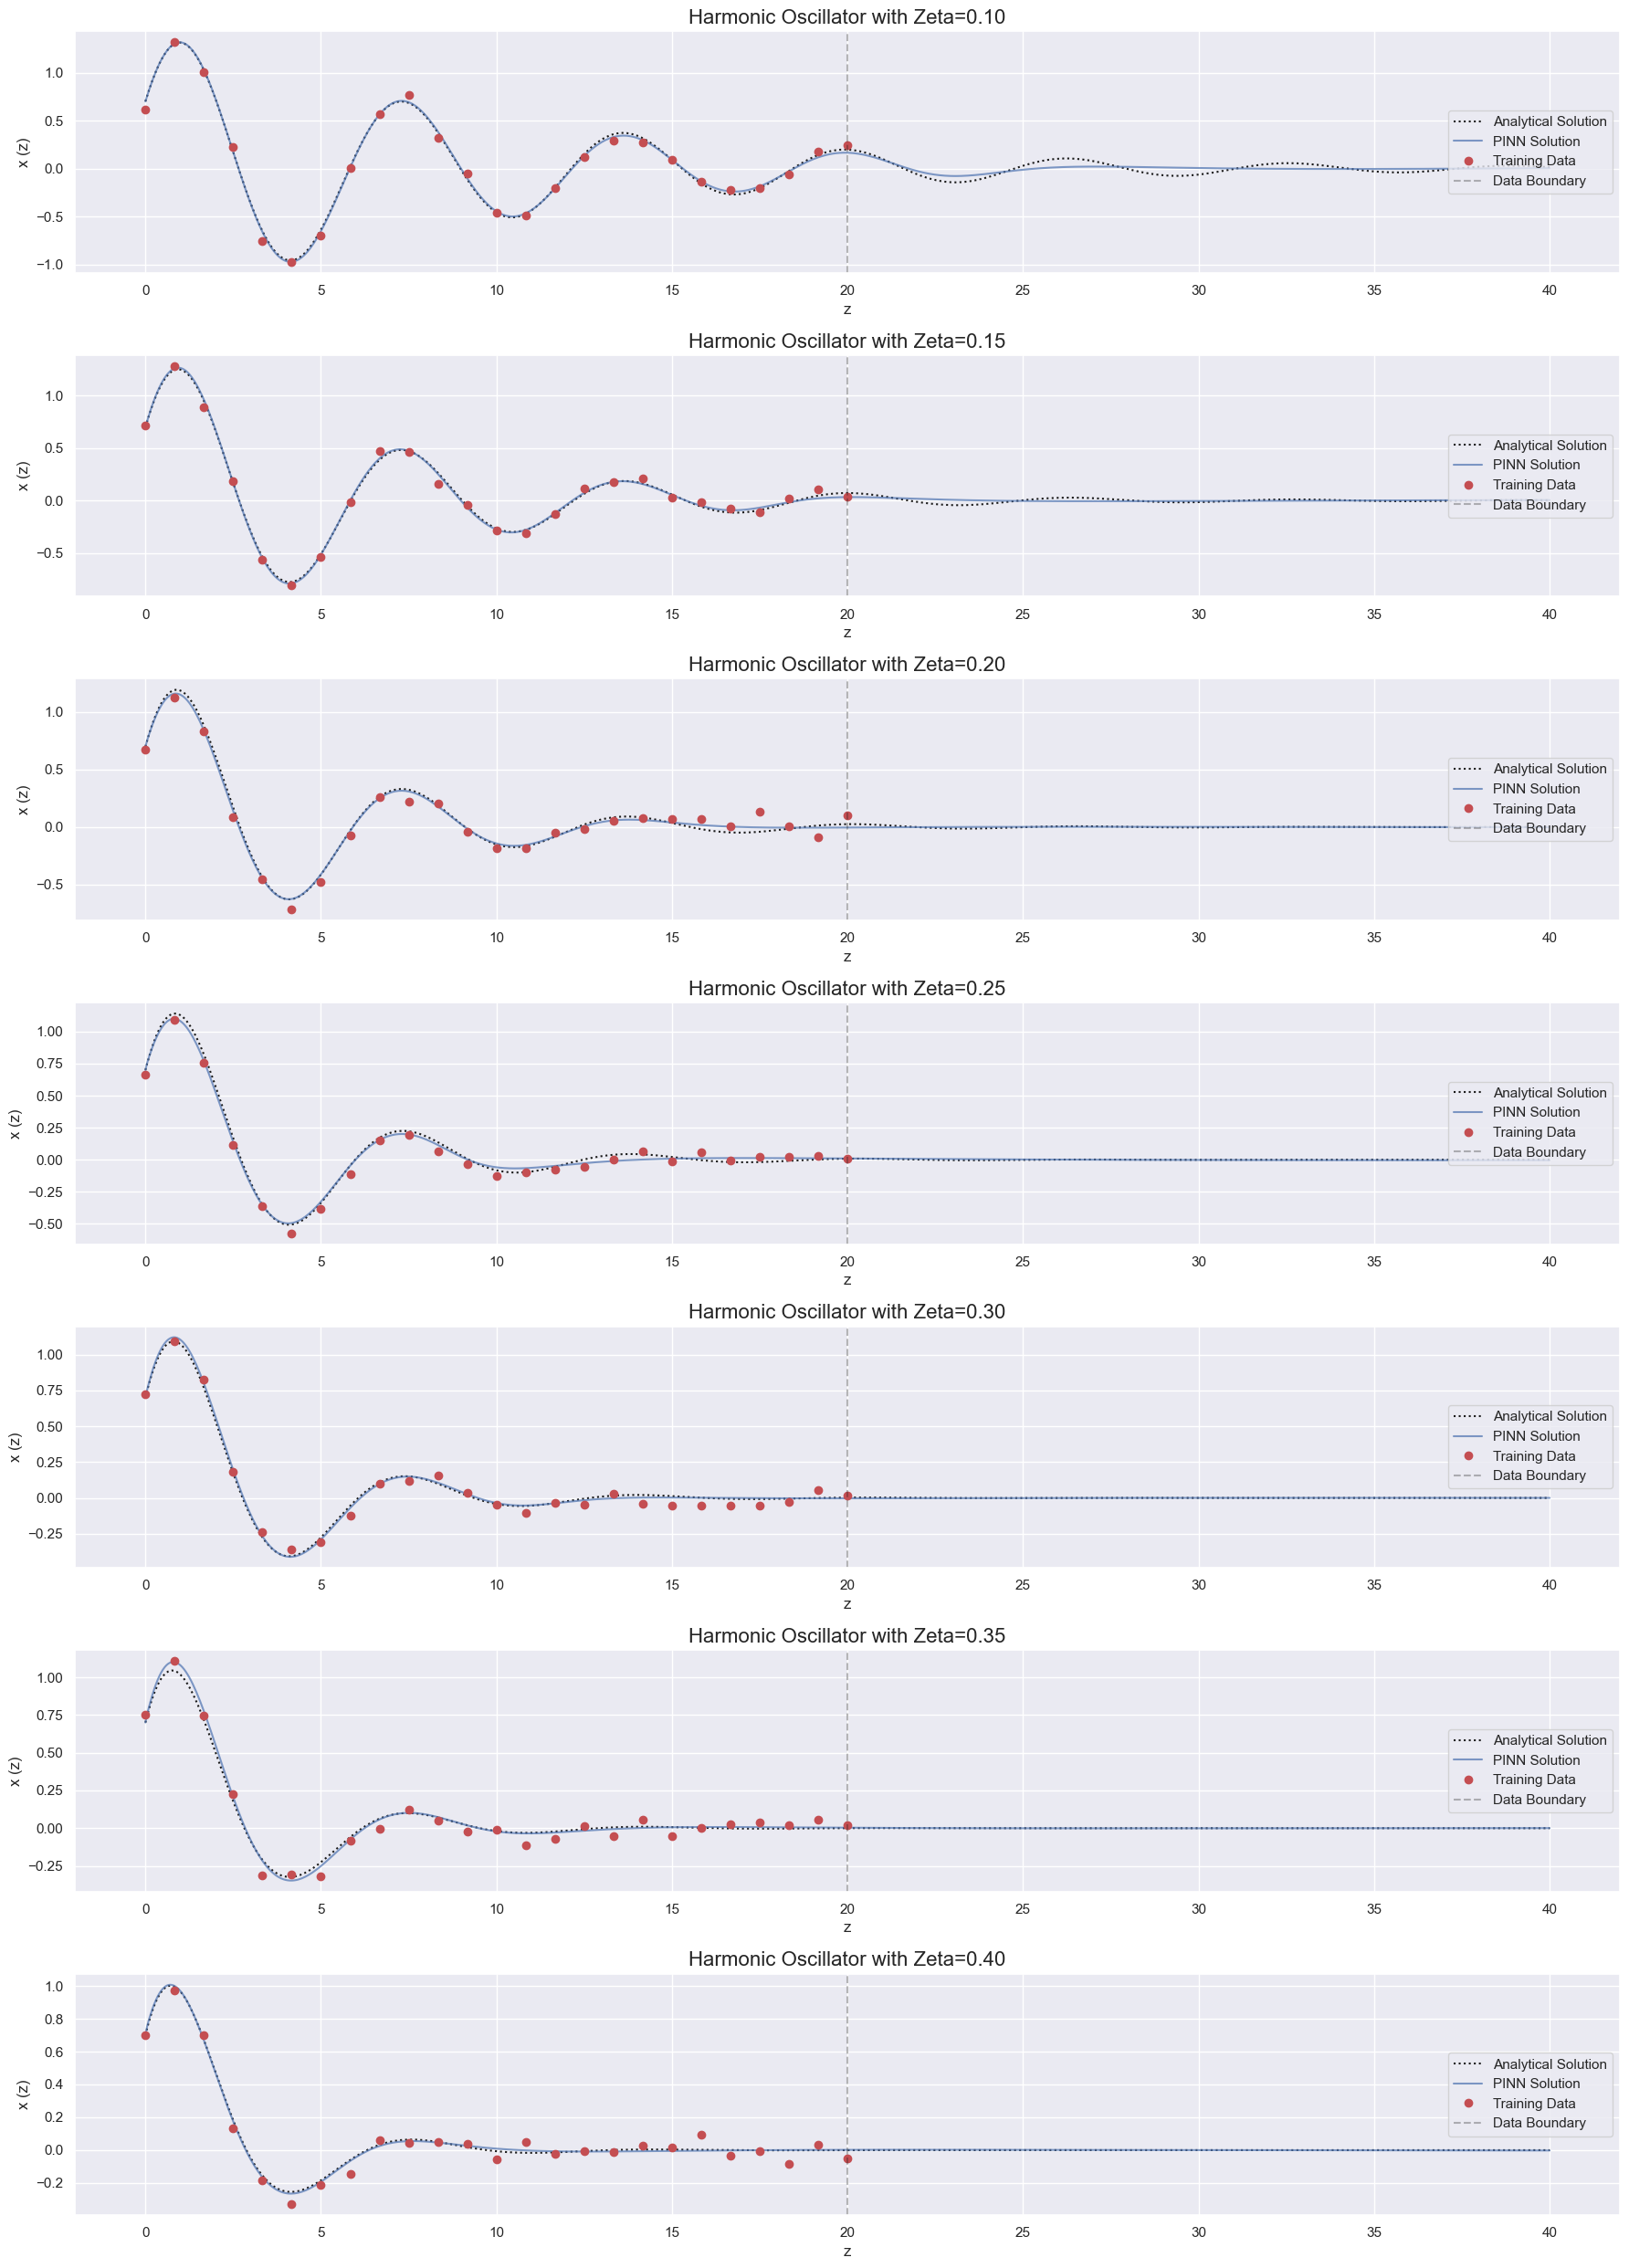

In [ ]:
# Training parameters
INPUT_DIM = 1
OUTPUT_DIM = 1
HIDDEN_UNITS = 64
NUM_EPOCHS = 20000
LEARNING_RATE = 1e-3

zetas = [0.1000, 0.1500, 0.2000, 0.2500, 0.3000, 0.3500, 0.4000]
models = {}
model_predictions = {}
datapoints_z_dict = {}
datapoints_x_dict = {}

datapoints_z_dict[f'zeta={zeta}'] = torch.linspace(0, 20, NUM_OF_TRAINING_POINTS)
datapoints_x_dict[f'zeta={zeta}'] = harmonic_oscillator(datapoints_z, zeta, C1, C2) + 0.05*torch.randn(NUM_OF_TRAINING_POINTS)

fig, axes = plt.subplots(len(zetas),1, figsize=(18,25))

for i, zeta in enumerate(zetas):
    z = torch.linspace(0,40,800)
    x_analytical = harmonic_oscillator(z, zeta, C1, C2)

    # Create and train the model
    models[f'zeta={zeta}'] = PINN(INPUT_DIM, OUTPUT_DIM, HIDDEN_UNITS).to(device)
    history = train_model(
        models[f'zeta={zeta}'], 
        datapoints_z_dict[f'zeta={zeta}'], 
        datapoints_x_dict[f'zeta={zeta}'], 
        zeta=zeta,  # Use your existing Xi value
        X_0=X_0,  # Initial position 
        V_0=V_0,  # Initial velocity
        lr=LEARNING_RATE, 
        num_epochs=NUM_EPOCHS,
        data_weight=0.05,
        physics_weight=0.50,
        ic_weight=0.25,
        plot_training=False
    )

    # Evaluate and plot results
    z_eval = torch.linspace(0, 40, 800).reshape(-1, 1).to(device)
    model_predictions[f'zeta={zeta}'] = models[f'zeta={zeta}'](z_eval).detach().cpu().numpy()

    axes[i].plot(z.numpy(), x_analytical.numpy(), 'k:', label='Analytical Solution')
    axes[i].plot(z_eval.numpy(), model_predictions[f'zeta={zeta}'], 'b-', alpha=0.7, label=f'PINN Solution')
    axes[i].plot(datapoints_z_dict[f'zeta={zeta}'].clone().numpy(), datapoints_x_dict[f'zeta={zeta}'].clone().numpy(), 'ro', label='Training Data')
    axes[i].axvline(x=20, color='k', linestyle='--', alpha=0.3, label='Data Boundary')
    axes[i].legend(loc='center right')
    axes[i].set_title(f'Harmonic Oscillator with Zeta={zeta:.2f}', fontsize=16)
    axes[i].set_xlabel('z')
    axes[i].set_ylabel('x (z)')

plt.tight_layout()

#### Pre-Trained PINNs for different zeta values

We can see that the solution curve given by the pre-trained PINN model shows slightly more closeness to the data points than the simple PINN model or we can say that it shows minute deviations from the analytical solution than simple PINN curve

Training: 100%|██████████| 20000/20000 [01:26<00:00, 232.30epoch/s, total=0.00022, data=0.00393, phys=0.00004, ic=0.00000]


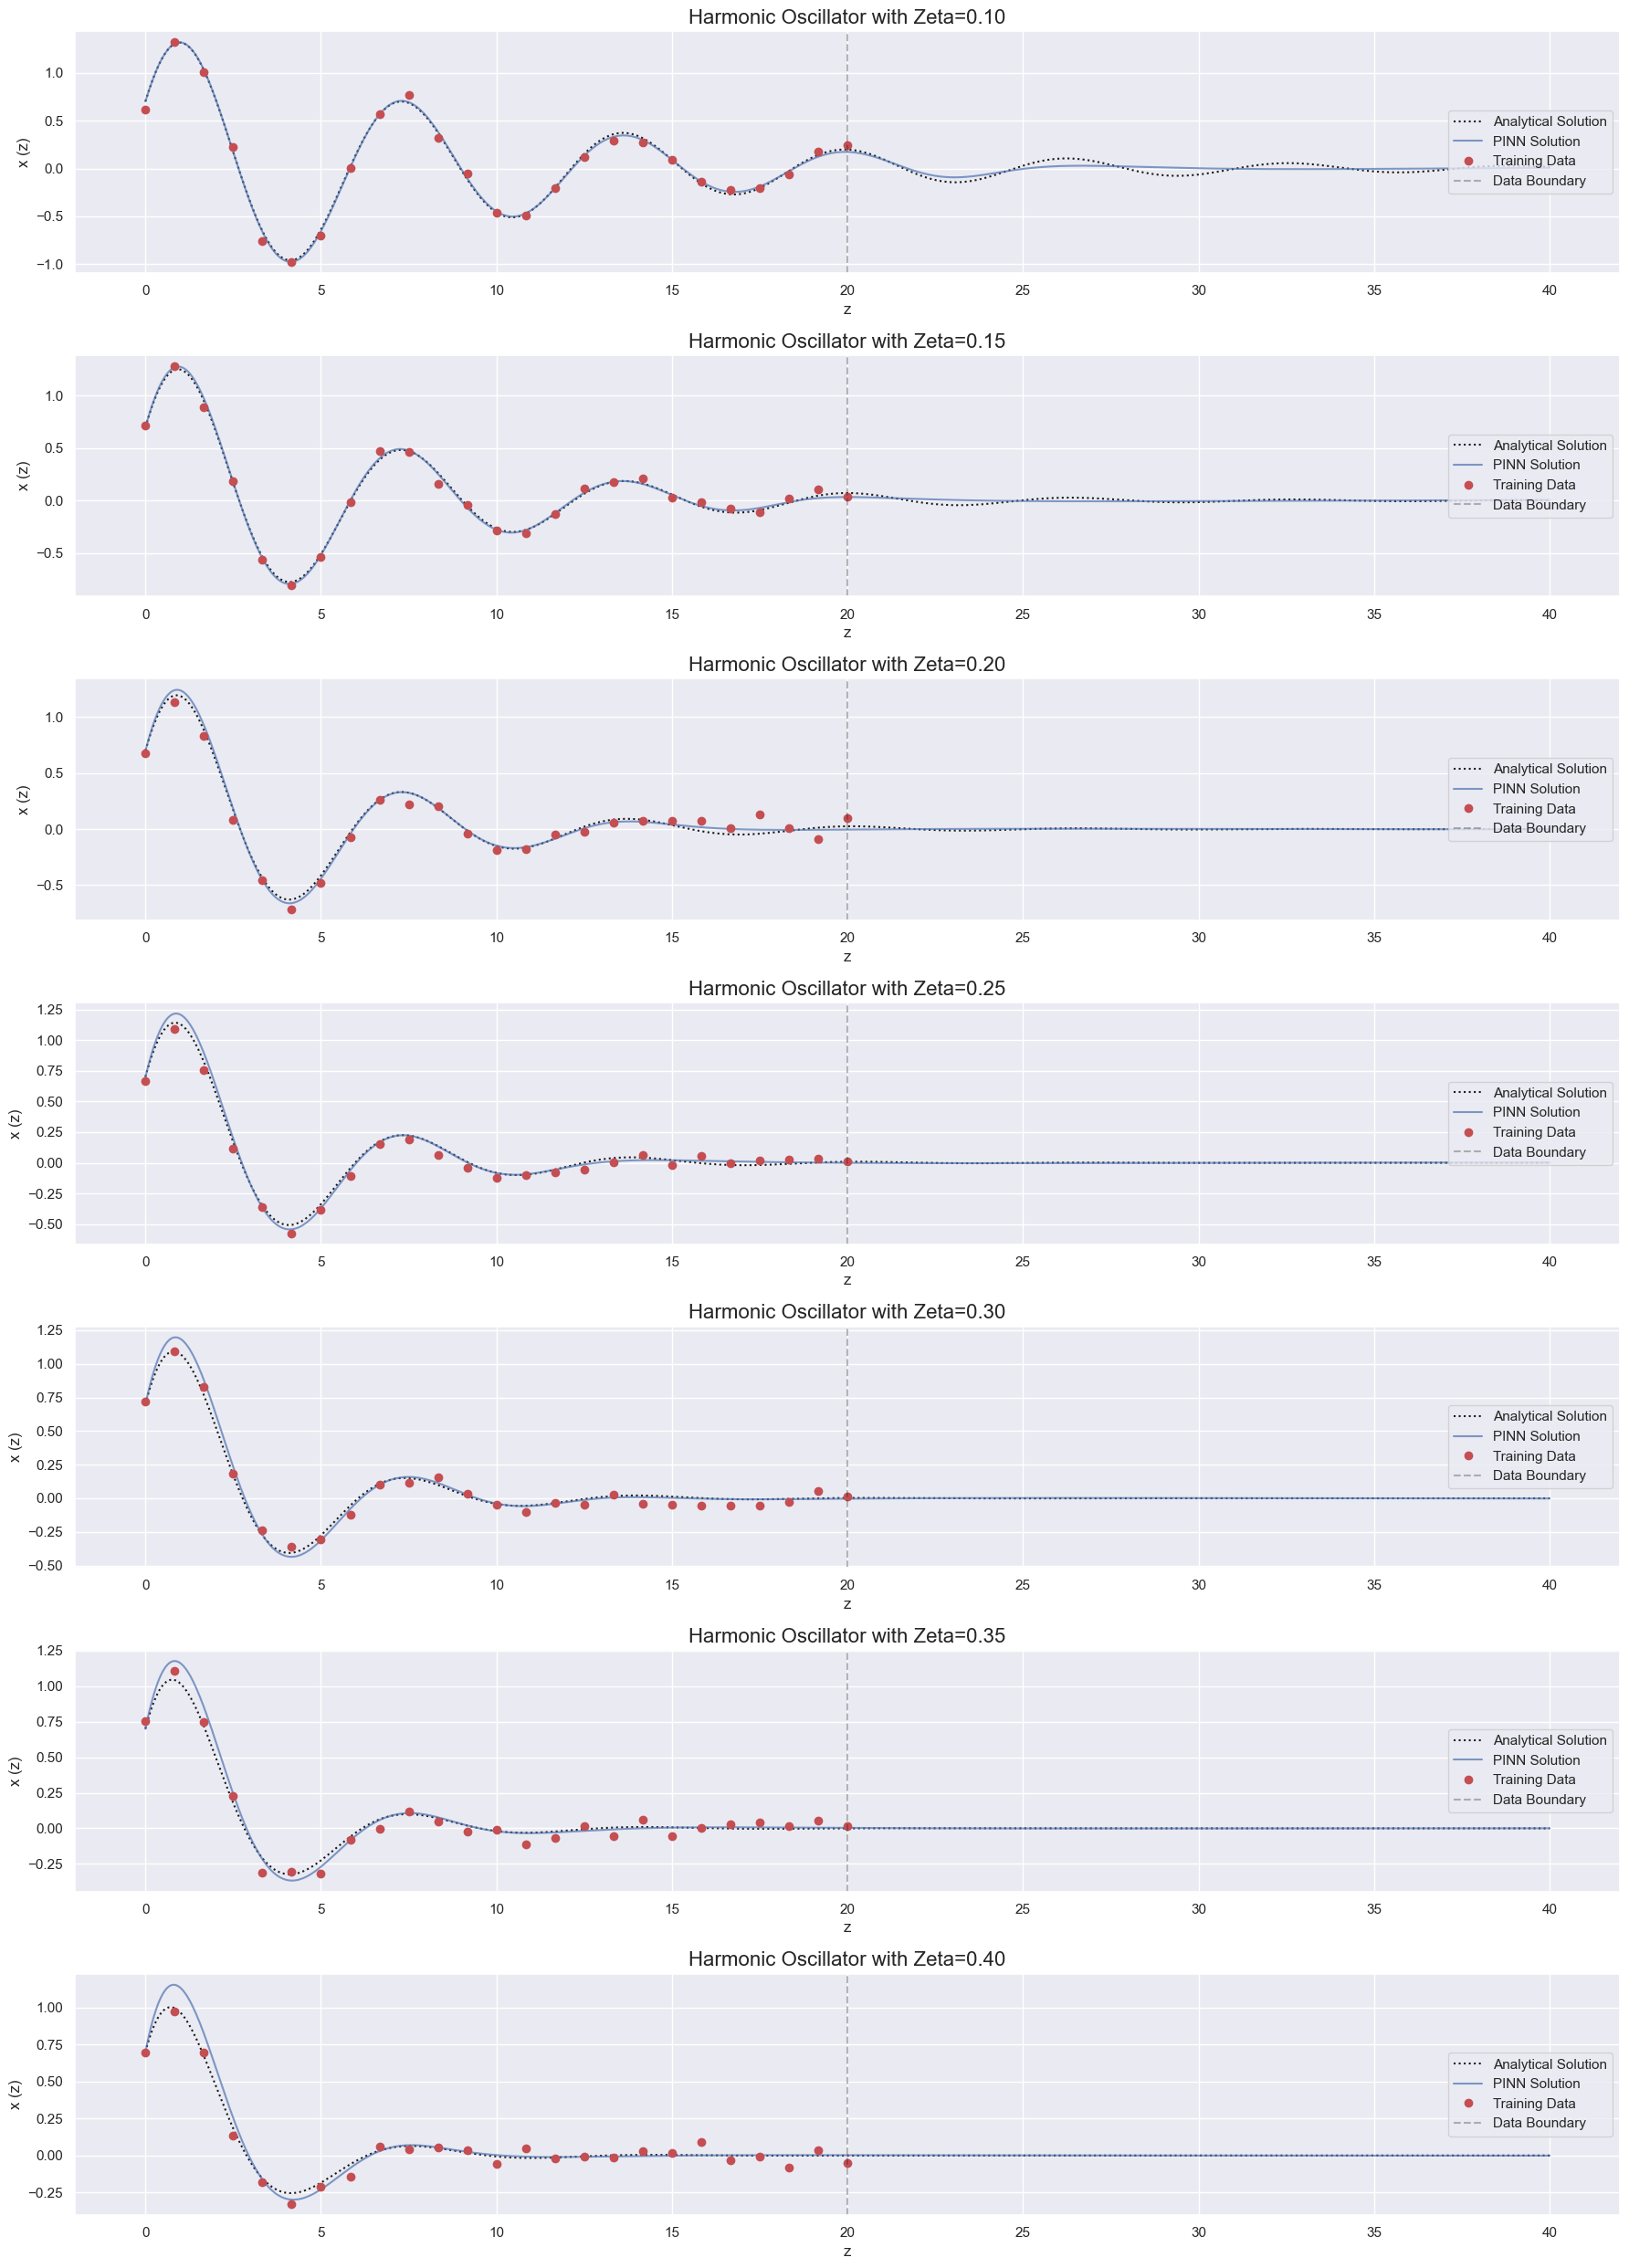

In [83]:
pretraining_models = {}
model_predictions = {}

fig, axes = plt.subplots(len(zetas),1, figsize=(18,25))

## Pre-Training PINN
for i, zeta in enumerate(zetas):
    z = torch.linspace(0,40,800)
    x_analytical = harmonic_oscillator(z, zeta, C1, C2)

    # Create and train the model
    pretraining_models[f'zeta={zeta}'] = PINN(INPUT_DIM, OUTPUT_DIM, HIDDEN_UNITS).to(device)

    ## Only Neural Network Training    
    history = train_model(
        pretraining_models[f'zeta={zeta}'], 
        datapoints_z_dict[f'zeta={zeta}'], 
        datapoints_x_dict[f'zeta={zeta}'], 
        zeta=zeta,  # Use your existing Xi value
        X_0=X_0,  # Initial position 
        V_0=V_0,  # Initial velocity
        lr=LEARNING_RATE, 
        num_epochs=NUM_EPOCHS,
        data_weight=0.05,
        physics_weight=0,
        ic_weight=0,
        plot_training=False
    )
    
    ## Physics Informed Neural Network
    history = train_model(
        pretraining_models[f'zeta={zeta}'], 
        datapoints_z_dict[f'zeta={zeta}'], 
        datapoints_x_dict[f'zeta={zeta}'], 
        zeta=zeta,  # Use your existing Xi value
        X_0=X_0,  # Initial position 
        V_0=V_0,  # Initial velocity
        lr=LEARNING_RATE, 
        num_epochs=NUM_EPOCHS,
        data_weight=0.05,
        physics_weight=0.50,
        ic_weight=0.25,
        plot_training=False
    )

    # Evaluate and plot results
    z_eval = torch.linspace(0, 40, 800).reshape(-1, 1).to(device)
    model_predictions[f'zeta={zeta}'] = pretraining_models[f'zeta={zeta}'](z_eval).detach().cpu().numpy()

    axes[i].plot(z.numpy(), x_analytical.numpy(), 'k:', label='Analytical Solution')
    axes[i].plot(z_eval.numpy(), model_predictions[f'zeta={zeta}'], 'b-', alpha=0.7, label=f'PINN Solution')
    axes[i].plot(datapoints_z_dict[f'zeta={zeta}'].clone().numpy(), datapoints_x_dict[f'zeta={zeta}'].clone().numpy(), 'ro', label='Training Data')
    axes[i].axvline(x=20, color='k', linestyle='--', alpha=0.3, label='Data Boundary')
    axes[i].legend(loc='center right')
    axes[i].set_title(f'Harmonic Oscillator with Zeta={zeta:.2f}', fontsize=16)
    axes[i].set_xlabel('z')
    axes[i].set_ylabel('x (z)')

plt.tight_layout()